# NH 투자증권 고객 데이터 분석 

## 사용할 패키지 불러오기 

사용할 패키지 불러오기 &
한글폰트 다운


In [1]:
! python --version

Python 3.7.15


In [2]:
! pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=ac8c0eef7cbc561d0620058d8dff81caea7cc6b8a4d7d3a61d947d5d3eea9f92
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [3]:
pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 한글 폰트 다운

In [4]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (20.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from pandasql import sqldf
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import rc
import numpy as np
from yellowbrick.cluster import SilhouetteVisualizer
import math
import zipfile
import warnings
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
rc('font', family='NanumBarunGothic')
# plt.rcParams['font.family'] = 'AppleGothic'


## 데이터 준비 & 데이터 확인

In [6]:
!gdown --id 1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
zf = zipfile.ZipFile("경진대회 예선 데이터.zip")
zf.setpassword(b"nh1212!")
zf.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
To: /content/경진대회 예선 데이터.zip
100% 12.5M/12.5M [00:00<00:00, 172MB/s]


In [7]:
info_data = pd.read_csv('./cus_ifo.csv')
kr_data = pd.read_csv('./kr_stk_orr.csv')
oss_data = pd.read_csv('./oss_stk_orr.csv')
cus_tot_data = pd.read_csv('./cus_tot_aet_ifo.csv')

고객의 1월부터 6월까지 거래 데이터 
고객 1000명

### 컬럼 이름 바꿔주기 

In [8]:
info_data.columns

Index(['cus_no', 'act_no', 'bse_ym', 'mts_mm_access_type', 'sex_dit_cd',
       'cus_age_stn_cd', 'cus_aet_stn_cd', 'pft_amt_stn_cd', 'fst_act_opn_dt',
       'stk_pdt_hld_yn', 'ose_stk_pdt_hld_yn', 'mrz_pdt_tp_sgm_cd',
       'lsg_sgm_cd', 'tco_cus_grd_cd', 'tot_ivs_te_sgm_cd',
       'hld_pdt_tp_sgm_cd', 'loy_sgm_cd', 'mrz_mkt_dit_cd', 'mrz_btp_dit_cd',
       'aet_bse_stk_trd_tp_cd', 'bas_stk_trd_tp_cd'],
      dtype='object')

In [9]:
def trans_kor(df, label):
    label = label.split('\n')
    # print(label)
    label_ = {}
    for l in label: 
        l = l.split('\t')
        key = l[0]
        value = l[1]
        label_[key] = value
    # print(label_)
    df = df.rename(columns=label_)
    # print(df.columns)

    return df

In [10]:
label = """cus_no	고객번호(가명화)
act_no	계좌번호(가명화)
bse_ym	고객정보기준년월 
cus_gb	고객단말구분
mts_mm_access_type	MTS월단위접속패턴
sex_dit_cd	성별
cus_age_stn_cd	연령대
cus_aet_stn_cd	고객자산구간코드
pft_amt_stn_cd	수익금액구간코드
fst_act_opn_dt	최초계좌개설일
stk_pdt_hld_yn	주식상품보유여부
ose_stk_pdt_hld_yn	해외주식상품보유여부
mrz_pdt_tp_sgm_cd	주거래상품군
lsg_sgm_cd	LIFESTAGE세그먼트코드
tco_cus_grd_cd	고객등급코드
tot_ivs_te_sgm_cd	총투자기간세그먼트코드
hld_pdt_tp_sgm_cd	보유상품유형세그먼트코드
loy_sgm_cd	충성도세그먼트코드
mrz_mkt_dit_cd	주거래시장구분코드
mrz_btp_dit_cd	주거래업종구분코드
aet_bse_stk_trd_tp_cd	자산기준주식거래유형코드
bas_stk_trd_tp_cd	기본주식거래유형코드
orr_dt	주문날짜
orr_ord	주문순서
orr_rtn_hur	주문접수시간대
lst_cns_hur	최종체결시간대
iem_cd	종목코드
sby_dit_cd	매매구분코드
cns_qty	체결건수
orr_pr	체결외화단가
orr_mdi_dit_cd	주문매체구분코드"""
info_data = trans_kor(info_data, label)

In [11]:
label = """act_no	계좌번호(가명화)
orr_dt	주문날짜
orr_ord	주문순서
orr_rtn_hur	주문접수시간대
lst_cns_hur	최종체결시간대
iem_cd	종목코드
sby_dit_cd	매매구분코드
cns_qty	체결건수
orr_pr	체결외화단가
orr_mdi_dit_cd	주문매체구분코드"""
kr_data = trans_kor(kr_data, label)


In [12]:
label = """act_no	계좌번호(가명화)
orr_dt	주문날짜
orr_ord	주문순서
orr_rtn_hur	주문접수시간대
lst_cns_hur	최종체결시간대
iem_cd	종목코드
sby_dit_cd	매매구분코드
cns_qty	체결건수
orr_pr	체결외화단가
orr_mdi_dit_cd	주문매체구분코드
cur_cd	거래통화코드
trd_cur_xcg_rt	거래통화환율"""
oss_data = trans_kor(oss_data, label)

In [13]:
label="""cus_no	고객번호(가명화)
act_no	계좌번호(가명화)
mts_mm_access_type	MTS월단위접속패턴
tot_aet_tld_rnd_202201	2022년 1월 총자산
tot_aet_tld_rnd_202202	2022년 2월 총자산
tot_aet_tld_rnd_202203	2022년 3월 총자산
tot_aet_tld_rnd_202204	2022년 4월 총자산
tot_aet_tld_rnd_202205	2022년 5월 총자산
tot_aet_tld_rnd_202206	2022년 6월 총자산"""
cus_tot_data = trans_kor(cus_tot_data, label)

# 데이터 EDA

### 데이터 처리


(총 거래 대금 *
총 거래 횟수 *
변동률 *
)
컬럼 만들기

총 거래 대금 *
총 거래 횟수 *
변동률 *
성별
연령대
고객자산구간코드
수익금액구간코드
LIFESTAGE세그먼트코드
총투자기간세그먼트코드
보유상품유형세그먼트코드
충성도세그먼트코드
주거래시장구분코드
주거래업종구분코드
기본주식거래유형코드

고객의 계좌 자산 데이터를 1~6월까지의 자산을 대표하는 변수를 생성하기 위해 변동률을 계산해줍니다. 
- 첫 자산 대비 마지막 자산의 변동률 계산 

**공식**
 - t : 계좌에 첫 자산
- end : 6월 계좌 자산

- $ \frac{end-t}{t} * 100 $

In [14]:
combined = pd.merge(info_data, cus_tot_data, how='left', on = ['고객번호(가명화)', '계좌번호(가명화)'] )

In [15]:
combined

,고객번호(가명화),계좌번호(가명화),고객정보기준년월,MTS월단위접속패턴_x,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,주거래업종구분코드,자산기준주식거래유형코드,기본주식거래유형코드,MTS월단위접속패턴_y,2022년 1월 총자산,2022년 2월 총자산,2022년 3월 총자산,2022년 4월 총자산,2022년 5월 총자산,2022년 6월 총자산
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202203,111111,1,4,1,1,20050309,Y,...,6.0,5.0,006,111111,1996586.0,2119266.0,2261986.0,1707630.0,1626697.0,1381982.0
1,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202202,111111,1,4,1,1,20050309,Y,...,16.0,5.0,010,111111,1996586.0,2119266.0,2261986.0,1707630.0,1626697.0,1381982.0
2,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,111111,1,4,1,1,20050309,Y,...,16.0,5.0,009,111111,1996586.0,2119266.0,2261986.0,1707630.0,1626697.0,1381982.0
3,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202205,111111,1,4,1,1,20050309,Y,...,16.0,5.0,008,111111,1996586.0,2119266.0,2261986.0,1707630.0,1626697.0,1381982.0
4,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202201,111111,1,4,1,1,20050309,Y,...,16.0,5.0,010,111111,1996586.0,2119266.0,2261986.0,1707630.0,1626697.0,1381982.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59076,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202204,110100,2,3,1,1,20210802,N,...,16.0,5.0,010,110100,9788.0,11041.0,12943.0,9508.0,8858.0,7757.0
59077,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202202,110100,2,3,1,1,20210802,N,...,16.0,5.0,010,110100,9788.0,11041.0,12943.0,9508.0,8858.0,7757.0
59078,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202206,110100,2,3,1,1,20210802,N,...,16.0,5.0,010,110100,9788.0,11041.0,12943.0,9508.0,8858.0,7757.0
59079,1b3dc5053fa9c52990872c97f85d54f3e8749eabf64b5d...,b41f38d7eedb84857fcc8fe2f58ded96aa3bbd85614d18...,202201,110100,2,3,1,1,20210802,N,...,16.0,5.0,010,110100,9788.0,11041.0,12943.0,9508.0,8858.0,7757.0


변동률을 계산할 때 분모에 0이 들어가지 않도록 
1씩 더해주기 

In [16]:
for k in range(1, 7):
    c = f'2022년 {k}월 총자산'
    combined[c] += 1 

In [17]:
def make_rate(df):
    rate = []
    
    last_name = '2022년 6월 총자산'

    for i in tqdm(range(len(df))):
        d = 1
        while True:
            aet_name = f'2022년 {d}월 총자산'
            
            if np.isnan(df[aet_name][i]) == True | (df[aet_name][i] == 0 & d != 6):
                d+=1 # 없으면 1씩 더하기 
            else:
                # 변동률 계산 
                rate.append((df[last_name][i] - df[aet_name][i]) / df[aet_name][i] * 100)
                
                break

    return [0 if math.isnan(x)  else x for x in rate]


combined['변동률'] = make_rate(combined)


100%|██████████| 59081/59081 [00:02<00:00, 21448.79it/s]


필요한 컬럼만 남기고 고객당 2022년 6월 데이터만 남기기 

inf 값 확인 

In [18]:
~np.isfinite(combined['변동률'])

0        False
1        False
2        False
3        False
4        False
         ...  
59076    False
59077    False
59078    False
59079    False
59080    False
Name: 변동률, Length: 59081, dtype: bool

In [19]:
combined[~np.isfinite(combined['변동률'])]

,고객번호(가명화),계좌번호(가명화),고객정보기준년월,MTS월단위접속패턴_x,성별,연령대,고객자산구간코드,수익금액구간코드,최초계좌개설일,주식상품보유여부,...,자산기준주식거래유형코드,기본주식거래유형코드,MTS월단위접속패턴_y,2022년 1월 총자산,2022년 2월 총자산,2022년 3월 총자산,2022년 4월 총자산,2022년 5월 총자산,2022년 6월 총자산,변동률


In [20]:
combined.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '고객정보기준년월 ', 'MTS월단위접속패턴_x', '성별', '연령대',
       '고객자산구간코드', '수익금액구간코드', '최초계좌개설일', '주식상품보유여부', '해외주식상품보유여부', '주거래상품군',
       'LIFESTAGE세그먼트코드', '고객등급코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드', '자산기준주식거래유형코드', '기본주식거래유형코드', 'MTS월단위접속패턴_y',
       '2022년 1월 총자산', '2022년 2월 총자산', '2022년 3월 총자산', '2022년 4월 총자산',
       '2022년 5월 총자산', '2022년 6월 총자산', '변동률'],
      dtype='object')

In [21]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59081 entries, 0 to 59080
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호(가명화)        59081 non-null  object 
 1   계좌번호(가명화)        59081 non-null  object 
 2   고객정보기준년월         59081 non-null  int64  
 3   MTS월단위접속패턴_x     59081 non-null  int64  
 4   성별               59081 non-null  int64  
 5   연령대              59081 non-null  int64  
 6   고객자산구간코드         59081 non-null  int64  
 7   수익금액구간코드         59081 non-null  int64  
 8   최초계좌개설일          59081 non-null  int64  
 9   주식상품보유여부         59081 non-null  object 
 10  해외주식상품보유여부       59081 non-null  object 
 11  주거래상품군           59081 non-null  int64  
 12  LIFESTAGE세그먼트코드  59081 non-null  int64  
 13  고객등급코드           59081 non-null  int64  
 14  총투자기간세그먼트코드      59081 non-null  int64  
 15  보유상품유형세그먼트코드     59075 non-null  float64
 16  충성도세그먼트코드        59075 non-null  float64
 17  주거래시장구분코드   

In [22]:
combined.value_counts('변동률')

변동률
 0.000000e+00    998
 1.500000e+06    112
 5.000000e+05    107
 1.000000e+06    105
-2.073693e+01     84
                ... 
-3.401771e+00      2
 7.681630e+04      2
 4.845290e+08      2
-2.012967e+01      2
-2.716334e+01      2
Length: 9622, dtype: int64

In [23]:
combined = combined[combined['고객정보기준년월 '] == 	202206	].reset_index(drop=True)

In [24]:
combined = combined[['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대',
       '고객자산구간코드', '수익금액구간코드', '해외주식상품보유여부', '주거래상품군',
       'LIFESTAGE세그먼트코드',  '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드', 
        '변동률']]

In [25]:
combined.value_counts('고객번호(가명화)').max()

1

In [26]:
combined.shape

(10000, 16)

거래횟수, 거래대금 가져오기

In [27]:
kr_data['총 금액'] = kr_data['체결건수'] * kr_data['체결외화단가'] 
oss_data['총 금액'] = oss_data['체결건수'] * oss_data['체결외화단가'] 


In [28]:
# 거래횟수
transactions_kor = kr_data.groupby('계좌번호(가명화)').count()['종목코드'].rename('국내주식 거래횟수')
transactions_oss = oss_data.groupby('계좌번호(가명화)').count()['종목코드'].rename('해외주식 거래횟수')

In [29]:
combined2 = combined.copy()

In [30]:
combined2 = pd.merge(combined2, transactions_kor, on='계좌번호(가명화)', how='left')
combined2 = pd.merge(combined2, transactions_oss, on='계좌번호(가명화)', how='left')

거래 안하는 사람 0으로 채우기 

In [31]:
# 거래대금
amount_kor = kr_data.groupby('계좌번호(가명화)').sum()['총 금액'].rename('국내주식 거래대금')
amount_oss = oss_data.groupby('계좌번호(가명화)').sum()['총 금액'].rename('해외주식 거래대금')

In [32]:
combined2 = pd.merge(combined2, amount_kor, on='계좌번호(가명화)', how='left')
combined2 = pd.merge(combined2, amount_oss, on='계좌번호(가명화)', how='left')

In [33]:
combined2.isnull().sum()

고객번호(가명화)             0
계좌번호(가명화)             0
성별                    0
연령대                   0
고객자산구간코드              0
수익금액구간코드              0
해외주식상품보유여부            0
주거래상품군                0
LIFESTAGE세그먼트코드       0
총투자기간세그먼트코드           0
보유상품유형세그먼트코드          1
충성도세그먼트코드             1
주거래시장구분코드            20
주거래업종구분코드            20
기본주식거래유형코드            1
변동률                   0
국내주식 거래횟수          3357
해외주식 거래횟수          9006
국내주식 거래대금          3357
해외주식 거래대금          9006
dtype: int64

In [34]:
for c in ['국내주식 거래횟수', '해외주식 거래횟수',  '국내주식 거래대금', '해외주식 거래대금' ]:
    combined2[c] = combined2[c].fillna(0)

In [35]:
combined2.isnull().sum()

고객번호(가명화)           0
계좌번호(가명화)           0
성별                  0
연령대                 0
고객자산구간코드            0
수익금액구간코드            0
해외주식상품보유여부          0
주거래상품군              0
LIFESTAGE세그먼트코드     0
총투자기간세그먼트코드         0
보유상품유형세그먼트코드        1
충성도세그먼트코드           1
주거래시장구분코드          20
주거래업종구분코드          20
기본주식거래유형코드          1
변동률                 0
국내주식 거래횟수           0
해외주식 거래횟수           0
국내주식 거래대금           0
해외주식 거래대금           0
dtype: int64

In [36]:
combined2[combined2['보유상품유형세그먼트코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
3789,21a2a6d469da94d0aeb8c5b7cc8d208f52e836f0fd77da...,ecf797801a24793ea3256ebd8bf7c4049aaa5e1ccada22...,1,99,3,1,N,99,99,99,NaN,NaN,2.0,10.0,NaN,-21.126857,633.0,0.0,1.773342e+09,0.0


보유상품유형코드의 NaN값은 cma 등의 다른 정보를 확인할 수 없으므로 미정의 99로 채운다. 

In [37]:
combined2['보유상품유형세그먼트코드'] = combined2['보유상품유형세그먼트코드'].fillna(99)

In [38]:
combined2[combined2['충성도세그먼트코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
3789,21a2a6d469da94d0aeb8c5b7cc8d208f52e836f0fd77da...,ecf797801a24793ea3256ebd8bf7c4049aaa5e1ccada22...,1,99,3,1,N,99,99,99,99.0,NaN,2.0,10.0,NaN,-21.126857,633.0,0.0,1.773342e+09,0.0


지도학습 

In [39]:
combined2.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금'],
      dtype='object')

In [40]:
X_train = combined2.dropna()[[ '성별', '연령대',
       '고객자산구간코드', '수익금액구간코드', '주거래상품군',
       'LIFESTAGE세그먼트코드',  '총투자기간세그먼트코드', '보유상품유형세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드',  
        '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]
y_train = combined2.dropna()['충성도세그먼트코드']
print(X_train.shape, y_train.shape)

(9979, 15) (9979,)


In [41]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [42]:
X_test = combined2[combined2['충성도세그먼트코드'].isnull()][[ '성별', '연령대',
       '고객자산구간코드', '수익금액구간코드', '주거래상품군',
       'LIFESTAGE세그먼트코드',  '총투자기간세그먼트코드', '보유상품유형세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드',  
        '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]

In [43]:
X_test

,성별,연령대,고객자산구간코드,수익금액구간코드,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,주거래시장구분코드,주거래업종구분코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
3789,1,99,3,1,99,99,99,99.0,2.0,10.0,-21.126857,633.0,0.0,1.773342e+09,0.0


In [44]:
knn_pred = knn.predict(X_test)


In [45]:
knn_pred

array([4.])

In [46]:
combined2['충성도세그먼트코드'].loc[3789] = 4.0

In [47]:
combined2[combined2['충성도세그먼트코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금


In [48]:
combined2[combined2['주거래시장구분코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
20,e6e2dd074eee06b13a841e37e8d9b05ae148fe1eb55b54...,7d5c754ffbab742a86d6fed2b9153098ef620e481cd151...,1,7,1,1,N,2,5,3,99.0,5.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
113,54abb694eebd4ae2345a7900e01c5c8030ae93fed18e37...,a16fca3d6812953d5903e261aa163eaf5e5f4083bcd342...,1,2,1,1,N,2,2,2,99.0,5.0,NaN,NaN,_,-99.999958,0.0,8.0,0.0,4052.3733
439,b6b897b95f3681930ad220d69ec49f1019111b7dfe77ff...,22ad345590a86725724423b9909171aa66579945abebca...,2,7,1,1,N,1,6,5,3.0,6.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
946,767a2b2439033b11e305dc33a3daf16271a0a48c5edec9...,77cbf2fd7d2f17f9745fa5e8d0a4d670357b26d389b1eb...,1,3,1,1,N,1,3,3,3.0,6.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
1148,ddfbcc14fd4759a3caa0291d1242ca9f01cdbdf720c4b3...,6ebf1393d4026bcb97760d661f116cb6bddea5c0178e0e...,1,6,1,1,N,1,5,5,3.0,6.0,NaN,NaN,_,0.074383,0.0,0.0,0.0,0.0000
1350,09744f3b29833518a9397052c5035580fb952a89792b18...,0661c648507eb0f7d58013c65ae1453ce80a4e205a437f...,2,99,1,1,N,2,10,1,99.0,5.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
1883,258d1d7e20b8a94d941ddcdfea650d8508041d35c991b1...,f4ec81d3e511807d17d34caee7d1aa3e1ce8753683470d...,1,7,1,1,N,2,7,3,99.0,5.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
2294,86cfdb385e4bf4c53b9bd083c76f0f41eaa6e95a9fbfa3...,774f15ed2a6411b9e5850afe679fda724d24b3a5841b89...,1,2,1,1,N,1,2,1,3.0,6.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000
2804,9a0424b68759b3fd4a649fd86393b5139fb31daa7332c0...,6e1a22112a0cffefd1af3523cf35d68368cc66b90d909f...,1,8,1,1,N,1,5,5,3.0,6.0,NaN,NaN,_,0.073632,0.0,0.0,0.0,0.0000
3673,aeaa61b32b886c877a4310685aaf9fdeaa7c81b2251a1e...,d4b2e25559626e5ddb5ed8cb6e365979ab7d24b9a494c2...,1,5,1,1,N,2,5,3,99.0,5.0,NaN,NaN,_,0.000000,0.0,0.0,0.0,0.0000


In [49]:
index = combined2[combined2['주거래시장구분코드'].isnull()].index
index

Int64Index([  20,  113,  439,  946, 1148, 1350, 1883, 2294, 2804, 3673, 6766,
            7297, 7417, 7420, 7451, 8519, 9025, 9035, 9498, 9720],
           dtype='int64')

지도학습 

In [50]:
X_train = combined2.dropna()[[ '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
        '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]
y_train = combined2.dropna()['주거래시장구분코드']

In [51]:
print(X_train.shape, y_train.shape)

(9979, 14) (9979,)


In [52]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [53]:
X_test = combined2.loc[index][['성별', '연령대', '고객자산구간코드', '수익금액구간코드',
        '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', 
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]
knn_pred = knn.predict(X_test)
knn_pred


array([6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6.])

In [54]:
combined2['주거래시장구분코드'].loc[index] = knn_pred

In [55]:
combined2[combined2['기본주식거래유형코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
3789,21a2a6d469da94d0aeb8c5b7cc8d208f52e836f0fd77da...,ecf797801a24793ea3256ebd8bf7c4049aaa5e1ccada22...,1,99,3,1,N,99,99,99,99.0,4.0,2.0,10.0,NaN,-21.126857,633.0,0.0,1.773342e+09,0.0


In [56]:
combined2[combined2['주거래업종구분코드'].isnull()]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
20,e6e2dd074eee06b13a841e37e8d9b05ae148fe1eb55b54...,7d5c754ffbab742a86d6fed2b9153098ef620e481cd151...,1,7,1,1,N,2,5,3,99.0,5.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
113,54abb694eebd4ae2345a7900e01c5c8030ae93fed18e37...,a16fca3d6812953d5903e261aa163eaf5e5f4083bcd342...,1,2,1,1,N,2,2,2,99.0,5.0,6.0,NaN,_,-99.999958,0.0,8.0,0.0,4052.3733
439,b6b897b95f3681930ad220d69ec49f1019111b7dfe77ff...,22ad345590a86725724423b9909171aa66579945abebca...,2,7,1,1,N,1,6,5,3.0,6.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
946,767a2b2439033b11e305dc33a3daf16271a0a48c5edec9...,77cbf2fd7d2f17f9745fa5e8d0a4d670357b26d389b1eb...,1,3,1,1,N,1,3,3,3.0,6.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
1148,ddfbcc14fd4759a3caa0291d1242ca9f01cdbdf720c4b3...,6ebf1393d4026bcb97760d661f116cb6bddea5c0178e0e...,1,6,1,1,N,1,5,5,3.0,6.0,6.0,NaN,_,0.074383,0.0,0.0,0.0,0.0000
1350,09744f3b29833518a9397052c5035580fb952a89792b18...,0661c648507eb0f7d58013c65ae1453ce80a4e205a437f...,2,99,1,1,N,2,10,1,99.0,5.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
1883,258d1d7e20b8a94d941ddcdfea650d8508041d35c991b1...,f4ec81d3e511807d17d34caee7d1aa3e1ce8753683470d...,1,7,1,1,N,2,7,3,99.0,5.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
2294,86cfdb385e4bf4c53b9bd083c76f0f41eaa6e95a9fbfa3...,774f15ed2a6411b9e5850afe679fda724d24b3a5841b89...,1,2,1,1,N,1,2,1,3.0,6.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000
2804,9a0424b68759b3fd4a649fd86393b5139fb31daa7332c0...,6e1a22112a0cffefd1af3523cf35d68368cc66b90d909f...,1,8,1,1,N,1,5,5,3.0,6.0,6.0,NaN,_,0.073632,0.0,0.0,0.0,0.0000
3673,aeaa61b32b886c877a4310685aaf9fdeaa7c81b2251a1e...,d4b2e25559626e5ddb5ed8cb6e365979ab7d24b9a494c2...,1,5,1,1,N,2,5,3,99.0,5.0,6.0,NaN,_,0.000000,0.0,0.0,0.0,0.0000


주거래 시장 구분이 모두 비매매이므로 주거래 업종도 16 비매매로 채워준다. 
 

In [57]:
combined2.value_counts('주거래업종구분코드')

주거래업종구분코드
16.0    6531
9.0      966
10.0     874
5.0      312
13.0     298
14.0     213
6.0      198
2.0      149
12.0     135
7.0       93
8.0       63
3.0       59
11.0      43
1.0       23
4.0       20
15.0       3
dtype: int64

In [58]:
combined2['주거래업종구분코드'] = combined2['주거래업종구분코드'].fillna(16.0)

In [59]:
combined2.isnull().sum()['주거래업종구분코드']

0

In [60]:
combined2.value_counts('기본주식거래유형코드')

기본주식거래유형코드
010    4766
004    1567
008     854
009     848
003     717
005     446
002     345
006     275
001      98
007      50
_        20
011      13
dtype: int64

In [61]:
combined2[(combined2['기본주식거래유형코드'].isnull()) ]

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금
3789,21a2a6d469da94d0aeb8c5b7cc8d208f52e836f0fd77da...,ecf797801a24793ea3256ebd8bf7c4049aaa5e1ccada22...,1,99,3,1,N,99,99,99,99.0,4.0,2.0,10.0,NaN,-21.126857,633.0,0.0,1.773342e+09,0.0


In [62]:
X_train = combined2.dropna()[[ '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
        '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', 
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]

y_train = combined2.dropna()['기본주식거래유형코드']

In [63]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [64]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)
X_test = combined2[combined2['기본주식거래유형코드'].isnull()][[ '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
        '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', 
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금']]
knn_pred = knn.predict(X_test)



In [65]:
knn_pred


array(['001'], dtype=object)

In [66]:
combined2['기본주식거래유형코드'].loc[3789] = '001'

In [67]:
combined2['총 거래횟수'] = combined2['국내주식 거래횟수'] + combined2['해외주식 거래횟수']
combined2['총 거래대금'] = combined2['국내주식 거래대금'] + combined2['해외주식 거래대금']

In [68]:
combined2.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금', '총 거래횟수',
       '총 거래대금'],
      dtype='object')

국내주식 거래 횟수
국내주식 거래 대금 
해외주식 거래 횟수
해외주식 거래 대금

고객 1000명의 데이터 

In [69]:
combined2

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,...,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금,총 거래횟수,총 거래대금
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,1,4,1,1,N,2,3,3,...,6.0,16.0,009,-3.078273e+01,3.0,0.0,431300.0,0.0,3.0,431300.0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,1,7,1,1,N,2,5,3,...,6.0,16.0,008,2.611599e+00,1.0,0.0,184800.0,0.0,1.0,184800.0
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,1,5,1,1,N,2,5,3,...,6.0,16.0,010,-7.675748e+01,6.0,0.0,58985.0,0.0,6.0,58985.0
3,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,1,6,5,1,N,2,7,4,...,6.0,16.0,008,2.930431e+00,1.0,0.0,9990000.0,0.0,1.0,9990000.0
4,a93943ad4a16323cd7ffb6efb3f52fe566139304ec6bde...,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,2,4,1,1,N,2,4,3,...,6.0,16.0,010,2.000000e+06,2.0,0.0,53400.0,0.0,2.0,53400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ce1052f9cbcde0c946012223d8e75a8c450b446dbf94f1...,331ebc85b76813b4f37ace30577786f061df9b5a559644...,1,8,1,1,N,2,5,1,...,6.0,16.0,010,1.040479e+02,0.0,0.0,0.0,0.0,0.0,0.0
9996,bd56add752a126362d7a469c73cdd577409bbbbf567c15...,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,1,2,1,1,N,2,2,1,...,6.0,16.0,010,2.500000e+05,0.0,0.0,0.0,0.0,0.0,0.0
9997,94f7caefe90ce173f26d077084b7a337bb0d84c198a91e...,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,2,3,1,1,Y,2,4,3,...,6.0,16.0,008,-8.303900e+00,101.0,0.0,43329570.0,0.0,101.0,43329570.0
9998,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,2,5,1,1,Y,2,8,1,...,6.0,16.0,010,-2.347287e+01,1.0,0.0,28450.0,0.0,1.0,28450.0


In [70]:
combined2.describe()

,성별,연령대,고객자산구간코드,수익금액구간코드,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,보유상품유형세그먼트코드,충성도세그먼트코드,주거래시장구분코드,주거래업종구분코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금,총 거래횟수,총 거래대금
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04
mean,1.672200,7.977300,1.585300,1.049600,2.128700,4.718300,2.655100,1.979000,4.394000,4.509100,13.572500,1.717938e+07,50.358600,5.190200,7.406716e+07,1.247618e+04,55.548800,7.407963e+07
std,3.928294,17.671927,1.068475,0.438816,1.168363,4.278455,1.631935,9.309942,0.923823,2.150995,3.781584,8.381676e+08,335.819203,101.581328,5.811739e+08,5.962207e+05,354.467082,5.812127e+08
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1.000000,3.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,4.000000,2.000000,10.000000,-2.092732e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,2.000000,5.000000,1.000000,1.000000,2.000000,5.000000,3.000000,1.000000,5.000000,6.000000,16.000000,-8.766636e+00,2.000000,0.000000,5.776550e+05,0.000000e+00,3.000000,5.815012e+05
75%,2.000000,7.000000,2.000000,1.000000,2.000000,6.000000,3.000000,1.000000,5.000000,6.000000,16.000000,1.348878e+01,13.000000,0.000000,9.426268e+06,0.000000e+00,15.000000,9.437116e+06
max,99.000000,99.000000,6.000000,13.000000,99.000000,99.000000,99.000000,99.000000,6.000000,6.000000,16.000000,8.152448e+10,20978.000000,5641.000000,2.882708e+10,5.605456e+07,20978.000000,2.882708e+10


In [71]:
combined2[['변동률',
'국내주식 거래횟수',
'해외주식 거래횟수',
'국내주식 거래대금',
'해외주식 거래대금',
'총 거래횟수',
'총 거래대금']].corr()

,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금,총 거래횟수,총 거래대금
변동률,1.000000,0.001492,-0.000696,0.021435,-0.000410,0.001214,0.021433
국내주식 거래횟수,0.001492,1.000000,0.037429,0.360321,0.015530,0.958118,0.360313
해외주식 거래횟수,-0.000696,0.037429,1.000000,0.018777,0.158525,0.322034,0.018938
국내주식 거래대금,0.021435,0.360321,0.018777,1.000000,0.064699,0.346746,0.999999
해외주식 거래대금,-0.000410,0.015530,0.158525,0.064699,1.000000,0.060143,0.065720
총 거래횟수,0.001214,0.958118,0.322034,0.346746,0.060143,1.000000,0.346785
총 거래대금,0.021433,0.360313,0.018938,0.999999,0.065720,0.346785,1.000000


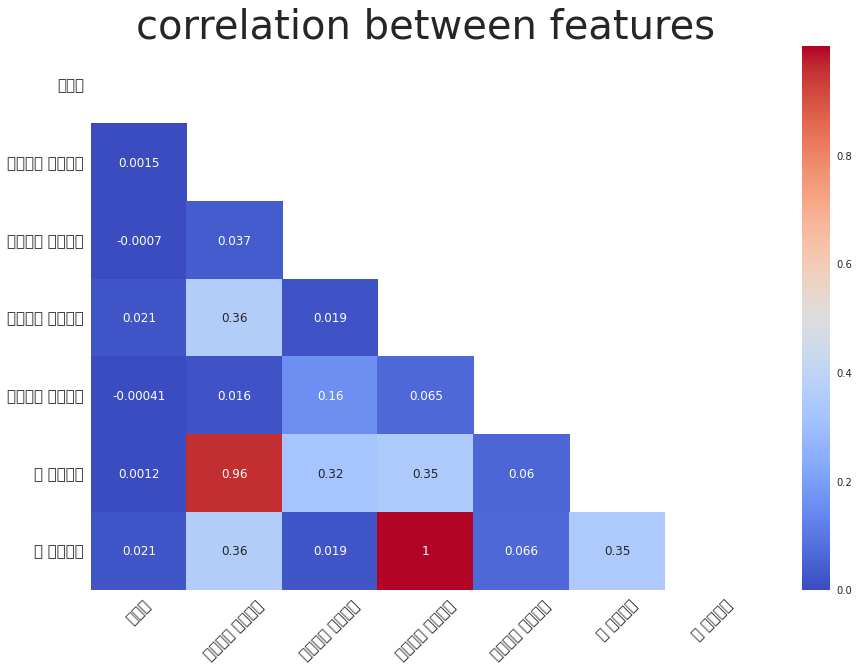

In [72]:
import numpy as np 

#상관관계 분석도

plt.figure(figsize=(15,10))

heat_table = combined2[['변동률',
'국내주식 거래횟수',
'해외주식 거래횟수',
'국내주식 거래대금',
'해외주식 거래대금',
'총 거래횟수',
'총 거래대금']].corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, mask = mask, cmap='coolwarm')
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=45)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15, rotation=0)
plt.title('correlation between features', fontsize=40)
plt.show()

국내주식 거래 대금이 큰 사람이 총 거래 대금도 크고 국내주식 거래를 많이 하는 사람의 거래횟수가 더 높은 것을 알 수 있다. 






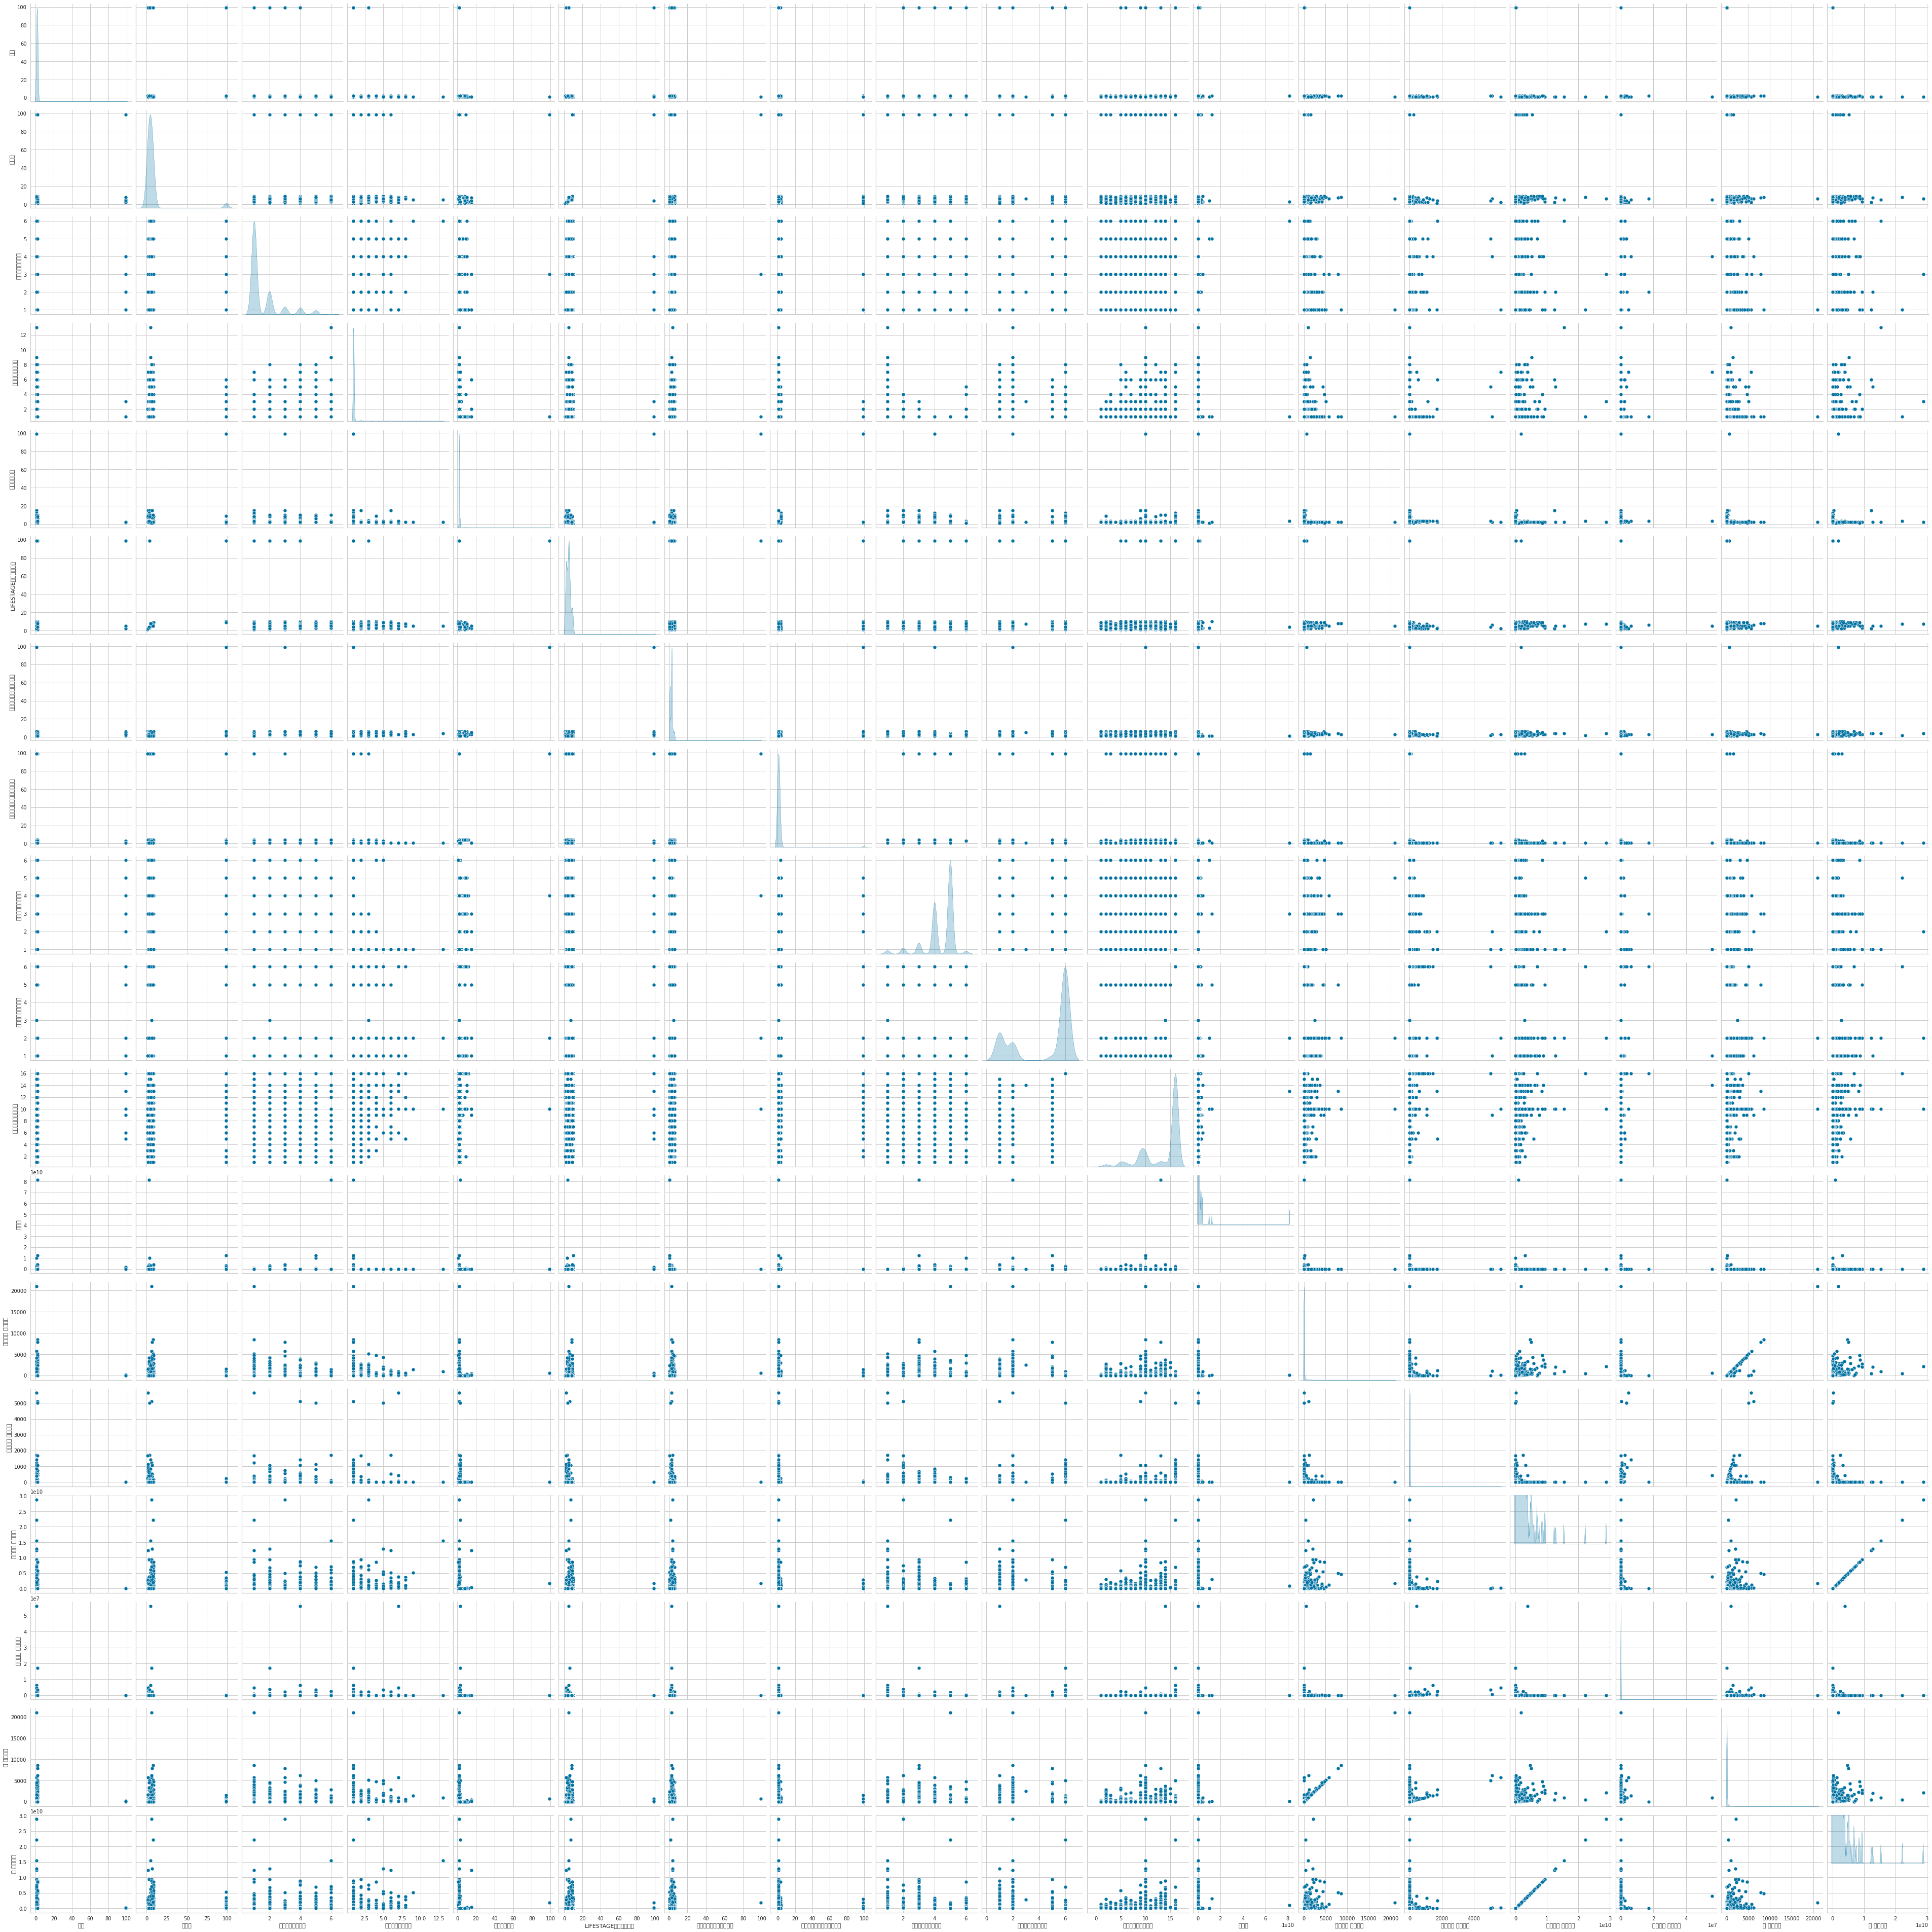

In [73]:
# 두 변수 간의 관계
sns.pairplot(combined2 , height = 3, diag_kind = 'kde')
plt.show()

In [74]:
combined2

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,...,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금,총 거래횟수,총 거래대금
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,1,4,1,1,N,2,3,3,...,6.0,16.0,009,-3.078273e+01,3.0,0.0,431300.0,0.0,3.0,431300.0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,1,7,1,1,N,2,5,3,...,6.0,16.0,008,2.611599e+00,1.0,0.0,184800.0,0.0,1.0,184800.0
2,dc6eb520d8a2ca7fcc5e95aef37120b8b1d91a3d30bd7e...,726a3295019efd88142038b123013623e26a217d2b08df...,1,5,1,1,N,2,5,3,...,6.0,16.0,010,-7.675748e+01,6.0,0.0,58985.0,0.0,6.0,58985.0
3,d11e0b4608537bc4cf260a2af2d5e04f0a1c58219c5008...,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,1,6,5,1,N,2,7,4,...,6.0,16.0,008,2.930431e+00,1.0,0.0,9990000.0,0.0,1.0,9990000.0
4,a93943ad4a16323cd7ffb6efb3f52fe566139304ec6bde...,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,2,4,1,1,N,2,4,3,...,6.0,16.0,010,2.000000e+06,2.0,0.0,53400.0,0.0,2.0,53400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,ce1052f9cbcde0c946012223d8e75a8c450b446dbf94f1...,331ebc85b76813b4f37ace30577786f061df9b5a559644...,1,8,1,1,N,2,5,1,...,6.0,16.0,010,1.040479e+02,0.0,0.0,0.0,0.0,0.0,0.0
9996,bd56add752a126362d7a469c73cdd577409bbbbf567c15...,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,1,2,1,1,N,2,2,1,...,6.0,16.0,010,2.500000e+05,0.0,0.0,0.0,0.0,0.0,0.0
9997,94f7caefe90ce173f26d077084b7a337bb0d84c198a91e...,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,2,3,1,1,Y,2,4,3,...,6.0,16.0,008,-8.303900e+00,101.0,0.0,43329570.0,0.0,101.0,43329570.0
9998,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,2,5,1,1,Y,2,8,1,...,6.0,16.0,010,-2.347287e+01,1.0,0.0,28450.0,0.0,1.0,28450.0


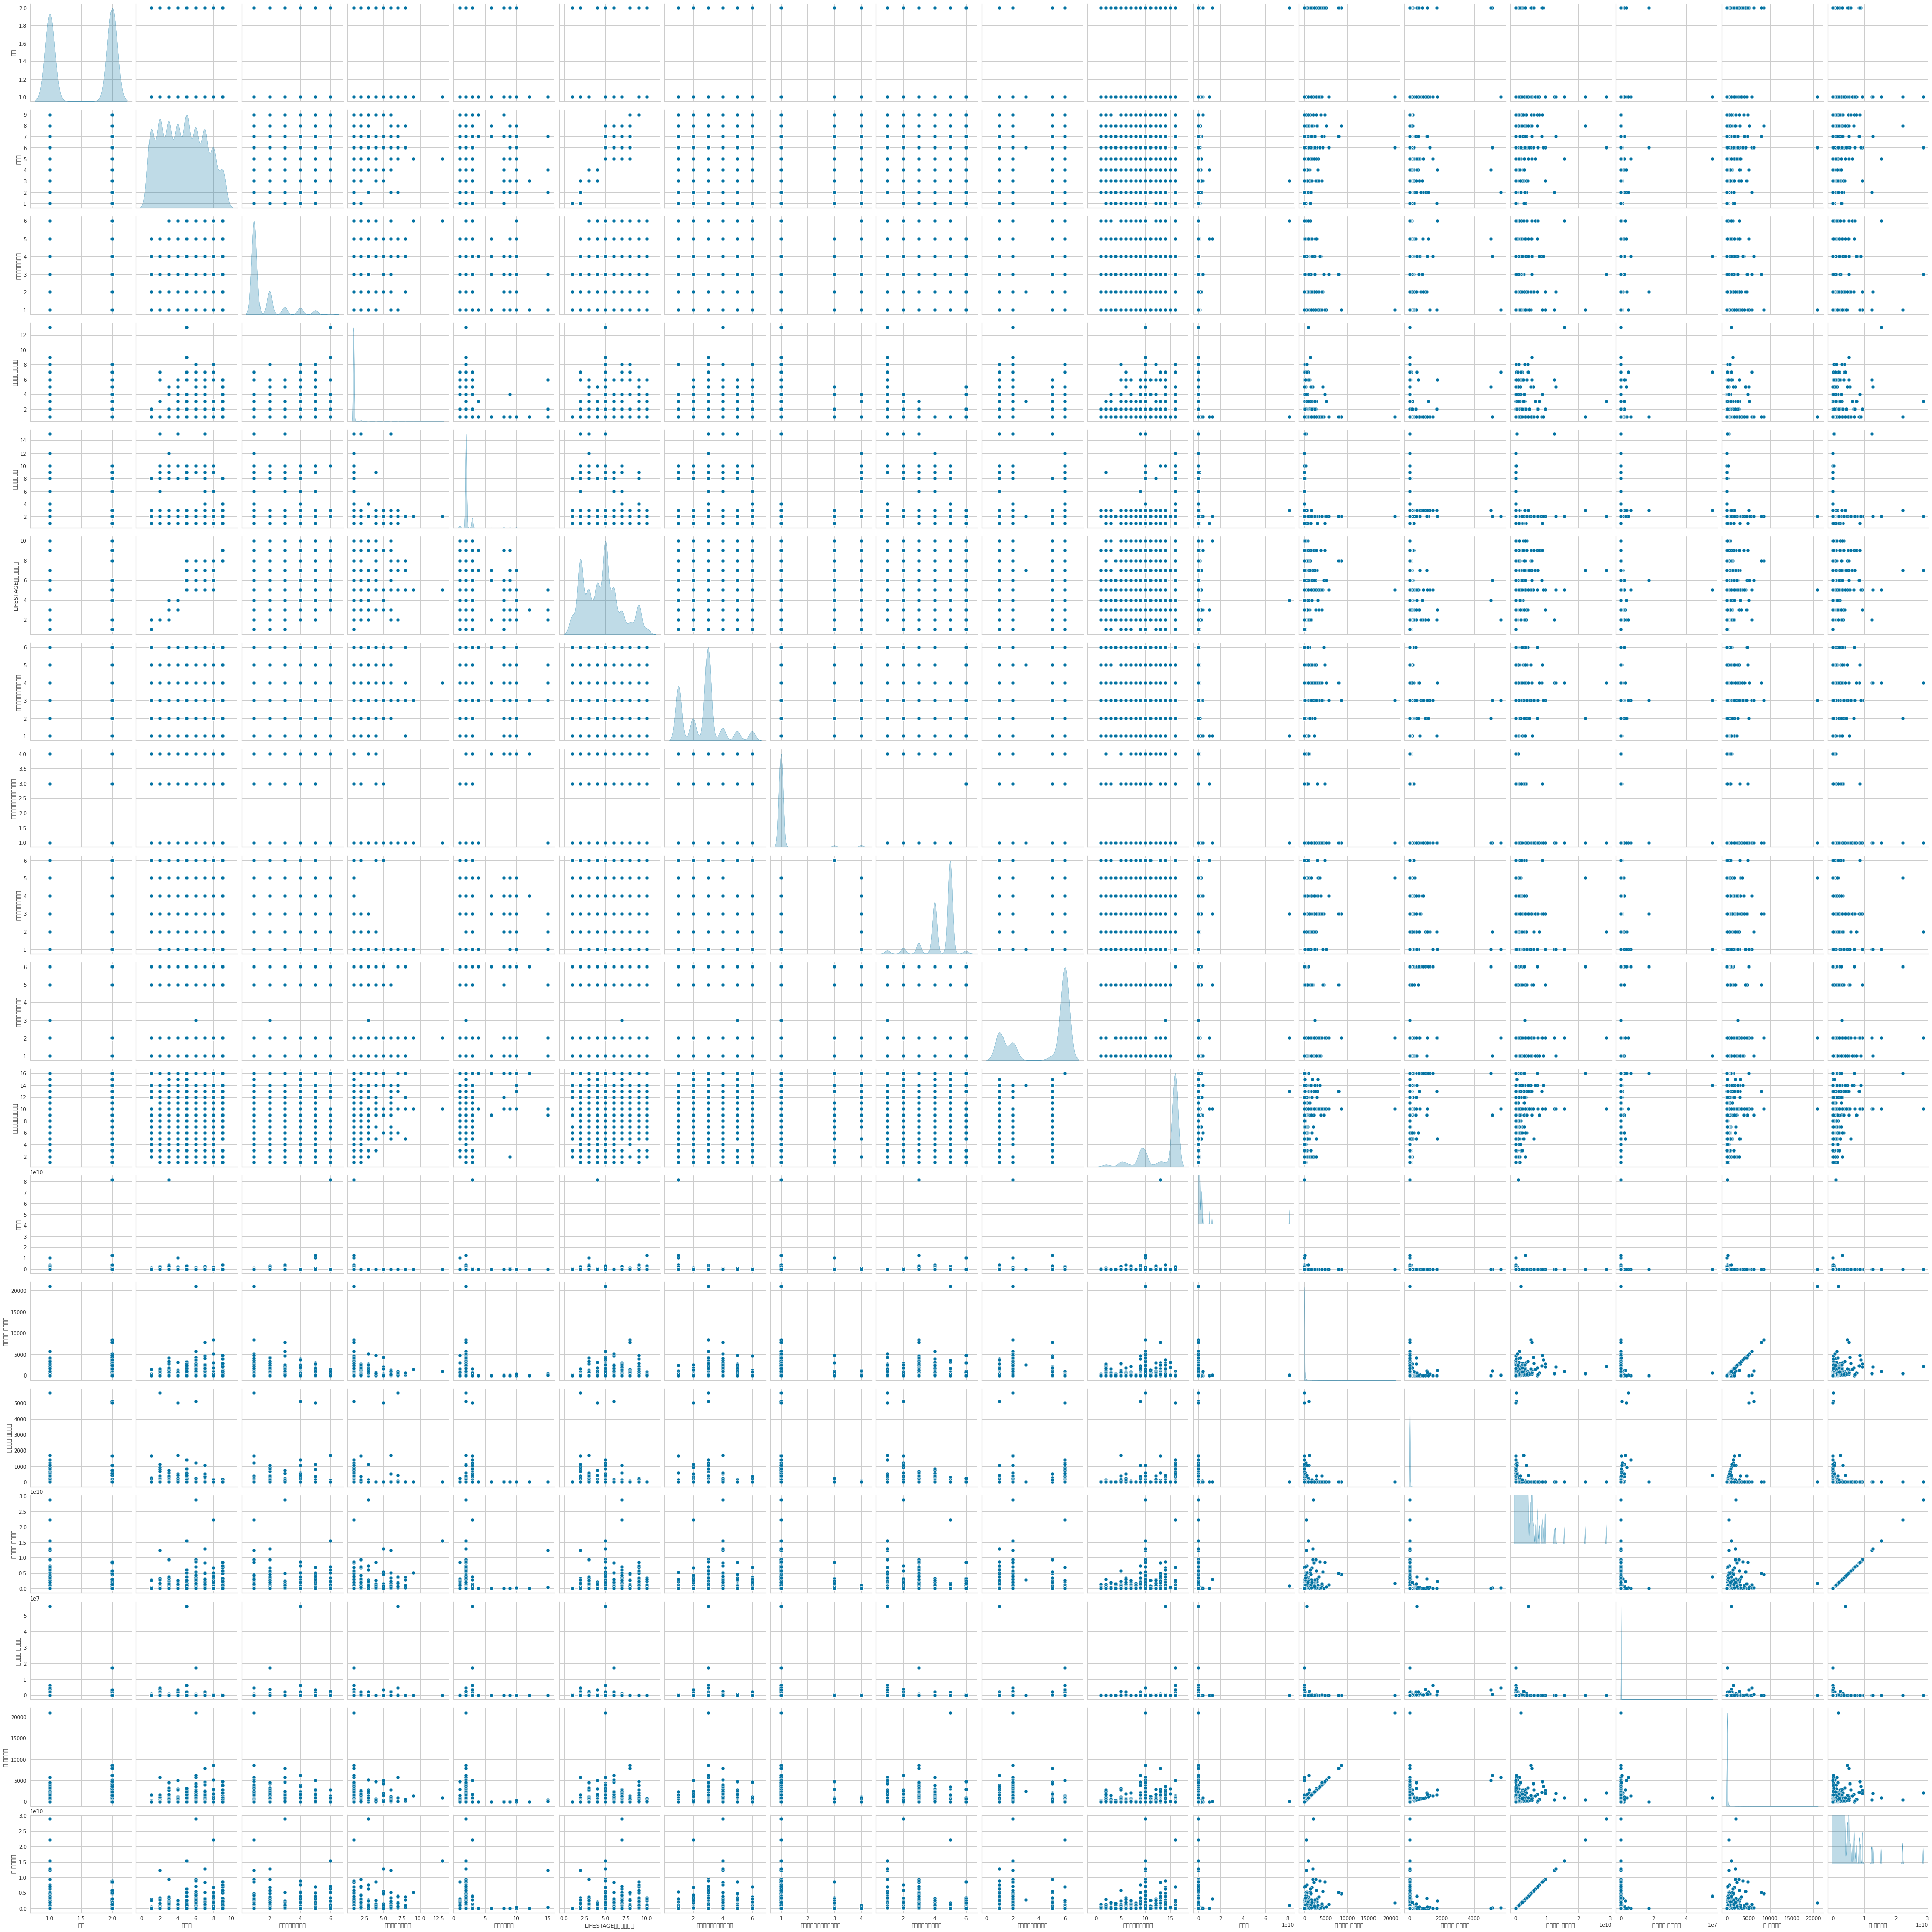

In [75]:
# 두 변수 간의 관계
sns.pairplot(combined2[combined2 != 99] , height = 3, diag_kind = 'kde')
plt.show()

위 그래프를 통해 알 수 있는 것은 다음과 같다.

총 거래대금, 거래 횟수가 높은 구간
- 남자가 주로 분포 

수익 구간 코드가 높은 구간
- 남자가 주로 분포 
- 40~50대 
  
변동률이 높은 구간
- 여자가 분포하고 있음 
- 30~35대 


발행어음이나 신용대출 등 더 다양하게 분포
 - 남자가 더 다양하게 분포함


수익금액 구간 : 거의 대부분이 10만원 미만 

In [76]:
combined2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   고객번호(가명화)        10000 non-null  object 
 1   계좌번호(가명화)        10000 non-null  object 
 2   성별               10000 non-null  int64  
 3   연령대              10000 non-null  int64  
 4   고객자산구간코드         10000 non-null  int64  
 5   수익금액구간코드         10000 non-null  int64  
 6   해외주식상품보유여부       10000 non-null  object 
 7   주거래상품군           10000 non-null  int64  
 8   LIFESTAGE세그먼트코드  10000 non-null  int64  
 9   총투자기간세그먼트코드      10000 non-null  int64  
 10  보유상품유형세그먼트코드     10000 non-null  float64
 11  충성도세그먼트코드        10000 non-null  float64
 12  주거래시장구분코드        10000 non-null  float64
 13  주거래업종구분코드        10000 non-null  float64
 14  기본주식거래유형코드       10000 non-null  object 
 15  변동률              10000 non-null  float64
 16  국내주식 거래횟수        10000 non-null  float64
 17  해외주식 거래횟수    

### 수치형 시각화 

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
numeric_feature = ['변동률',
'국내주식 거래횟수',
'해외주식 거래횟수',
'국내주식 거래대금',
'해외주식 거래대금',
'총 거래횟수',
'총 거래대금'] 

categorical_feature = ['성별', '연령대', '고객자산구간코드', '수익금액구간코드', '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드'] 


In [78]:
print(len(numeric_feature), len(categorical_feature))

7 13


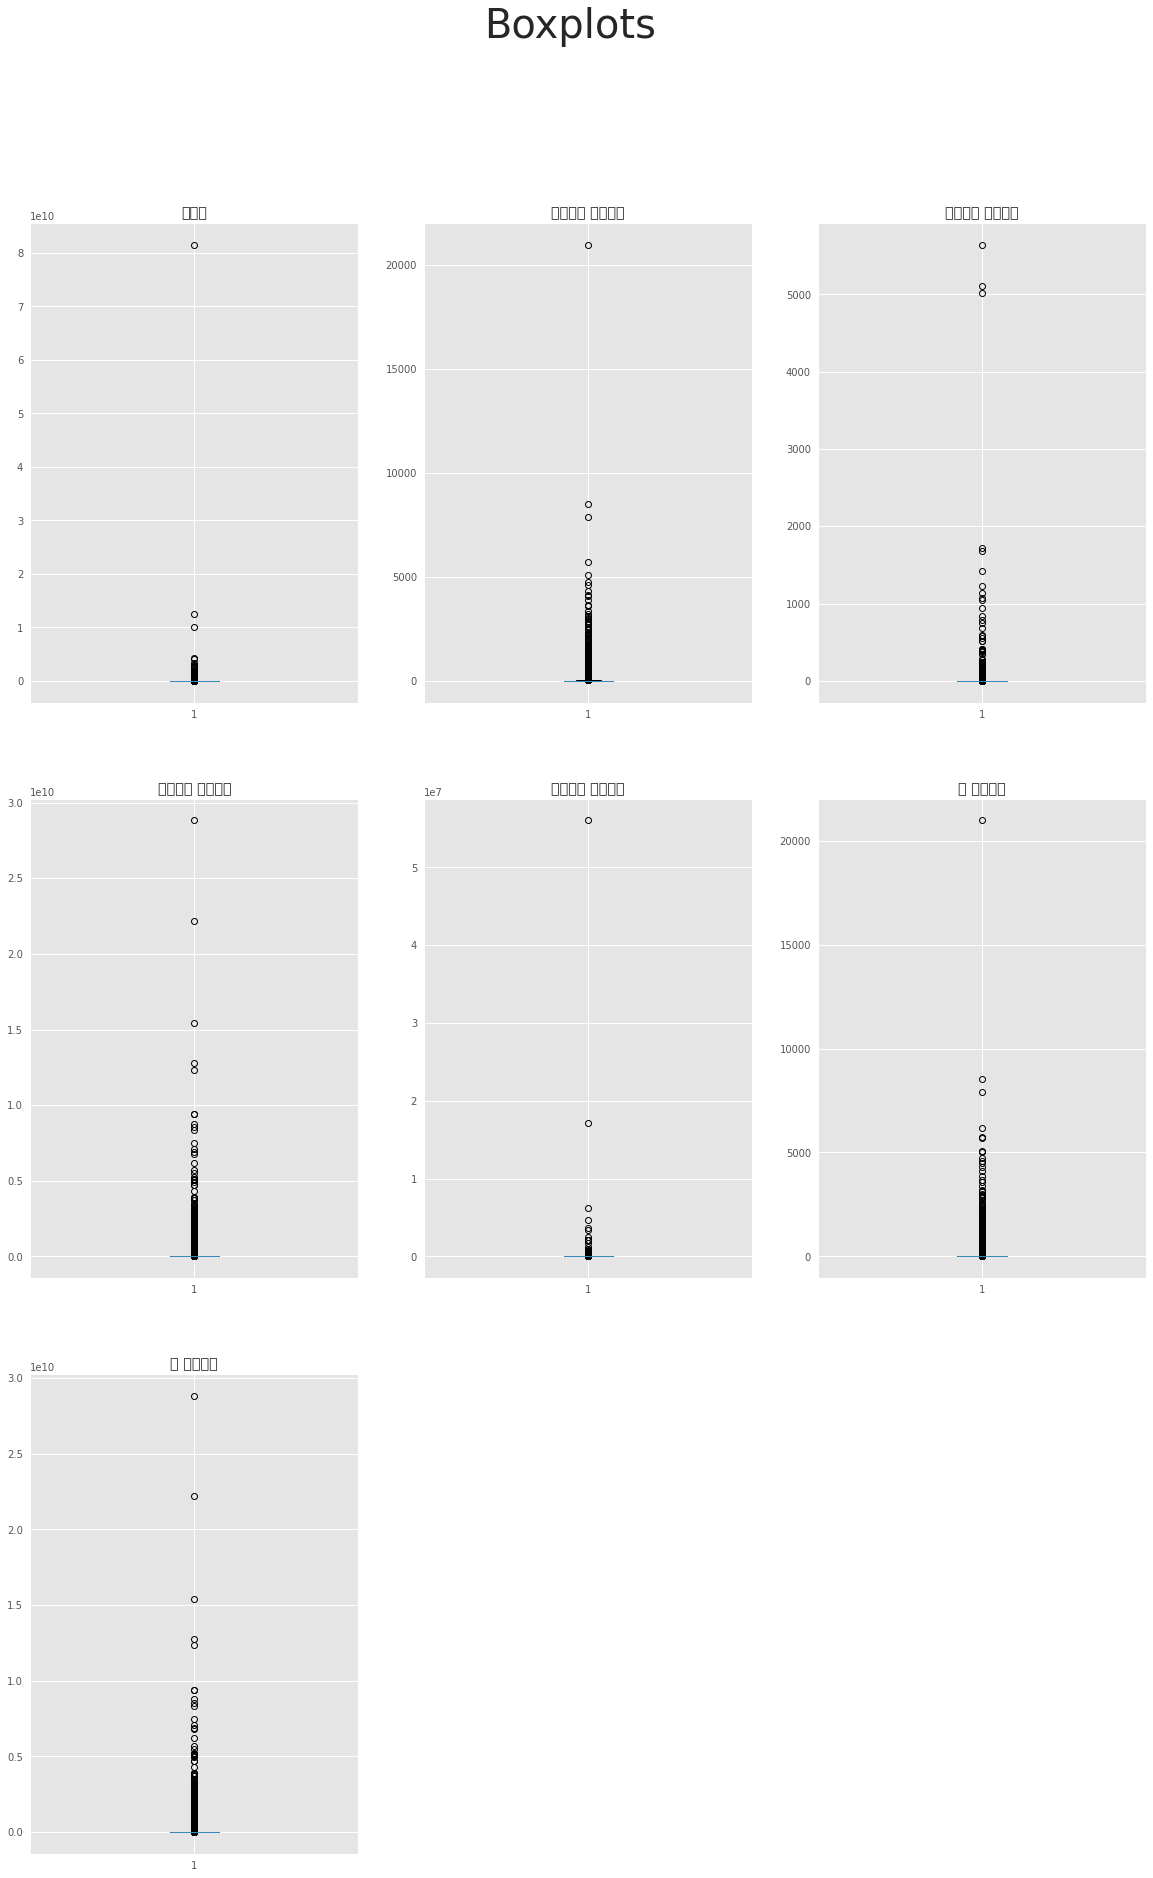

In [79]:

feature = numeric_feature


plt.figure(figsize=(20,30))
plt.suptitle("Boxplots", fontsize=40)

for i in range(len(feature)):
    plt.subplot(3,3,i+1)
    plt.title(feature[i])
    plt.boxplot(combined2[feature[i]])
plt.show()

In [80]:
def detect_outliers(df,columns):
    q1=df[columns].quantile(0.25)
    q3=df[columns].quantile(0.75)
    iqr=q3-q1
    
    boundary=1.5*iqr
    
    index1=df[df[columns] > q3+boundary].index
    index2=df[df[columns] < q1-boundary].index 
    
    df=df.drop(index1)
    df=df.drop(index2)
    
    return df

In [81]:
combined3 = combined2.copy()

feature = numeric_feature

for i in feature:
    combined3 = detect_outliers(combined3,i)



In [82]:
combined3

,고객번호(가명화),계좌번호(가명화),성별,연령대,고객자산구간코드,수익금액구간코드,해외주식상품보유여부,주거래상품군,LIFESTAGE세그먼트코드,총투자기간세그먼트코드,...,주거래시장구분코드,주거래업종구분코드,기본주식거래유형코드,변동률,국내주식 거래횟수,해외주식 거래횟수,국내주식 거래대금,해외주식 거래대금,총 거래횟수,총 거래대금
0,92ed7cdc3e3673226a613892c47a8eccfe602d0fbdb349...,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,1,4,1,1,N,2,3,3,...,6.0,16.0,009,-30.782731,3.0,0.0,431300.0,0.0,3.0,431300.0
1,3072d776c716010235dd75b3195d760bf3c46e00deee4e...,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,1,7,1,1,N,2,5,3,...,6.0,16.0,008,2.611599,1.0,0.0,184800.0,0.0,1.0,184800.0
5,ff6680be8395283839f6cd930d473ff222af176c10249b...,f7310c919e32e5857cf1252ff2500ef4a264ee8677e481...,2,9,2,1,N,2,9,3,...,6.0,16.0,010,-19.313162,0.0,0.0,0.0,0.0,0.0,0.0
10,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,2,8,2,1,Y,2,6,3,...,6.0,16.0,010,-11.777487,1.0,0.0,477000.0,0.0,1.0,477000.0
13,a345a883c5e3cbed8e59669da283f020500c16aa2c72ef...,71fc3f16d37209d312888d0d31f05c7570b64c643bc279...,2,4,1,1,N,2,4,3,...,6.0,16.0,010,-53.917340,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986,b87bec80c38acbedd6b6ec94e21c6175c6151951ac2b8c...,ec75edba8de3efe29149481de07a118e3f73e861a2c096...,2,8,1,1,N,2,6,3,...,6.0,16.0,010,-24.052609,0.0,0.0,0.0,0.0,0.0,0.0
9988,412782bb685a9552d20e3ee1f1e48e1a3749ef52d25cf5...,dcabb6904767e9eeae7deb60816f602a4ad0d14aa69c69...,2,4,1,1,N,2,4,1,...,6.0,16.0,010,4.385388,1.0,0.0,82400.0,0.0,1.0,82400.0
9989,ac9bbff59d6c92b6b135f50be374267b5920ca6fc7d398...,a13eec22a74674e8a0951c0bf4166389f3ae5789b0ae90...,2,7,1,1,N,2,5,5,...,6.0,16.0,010,-49.742010,0.0,0.0,0.0,0.0,0.0,0.0
9998,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,2,5,1,1,Y,2,8,1,...,6.0,16.0,010,-23.472870,1.0,0.0,28450.0,0.0,1.0,28450.0


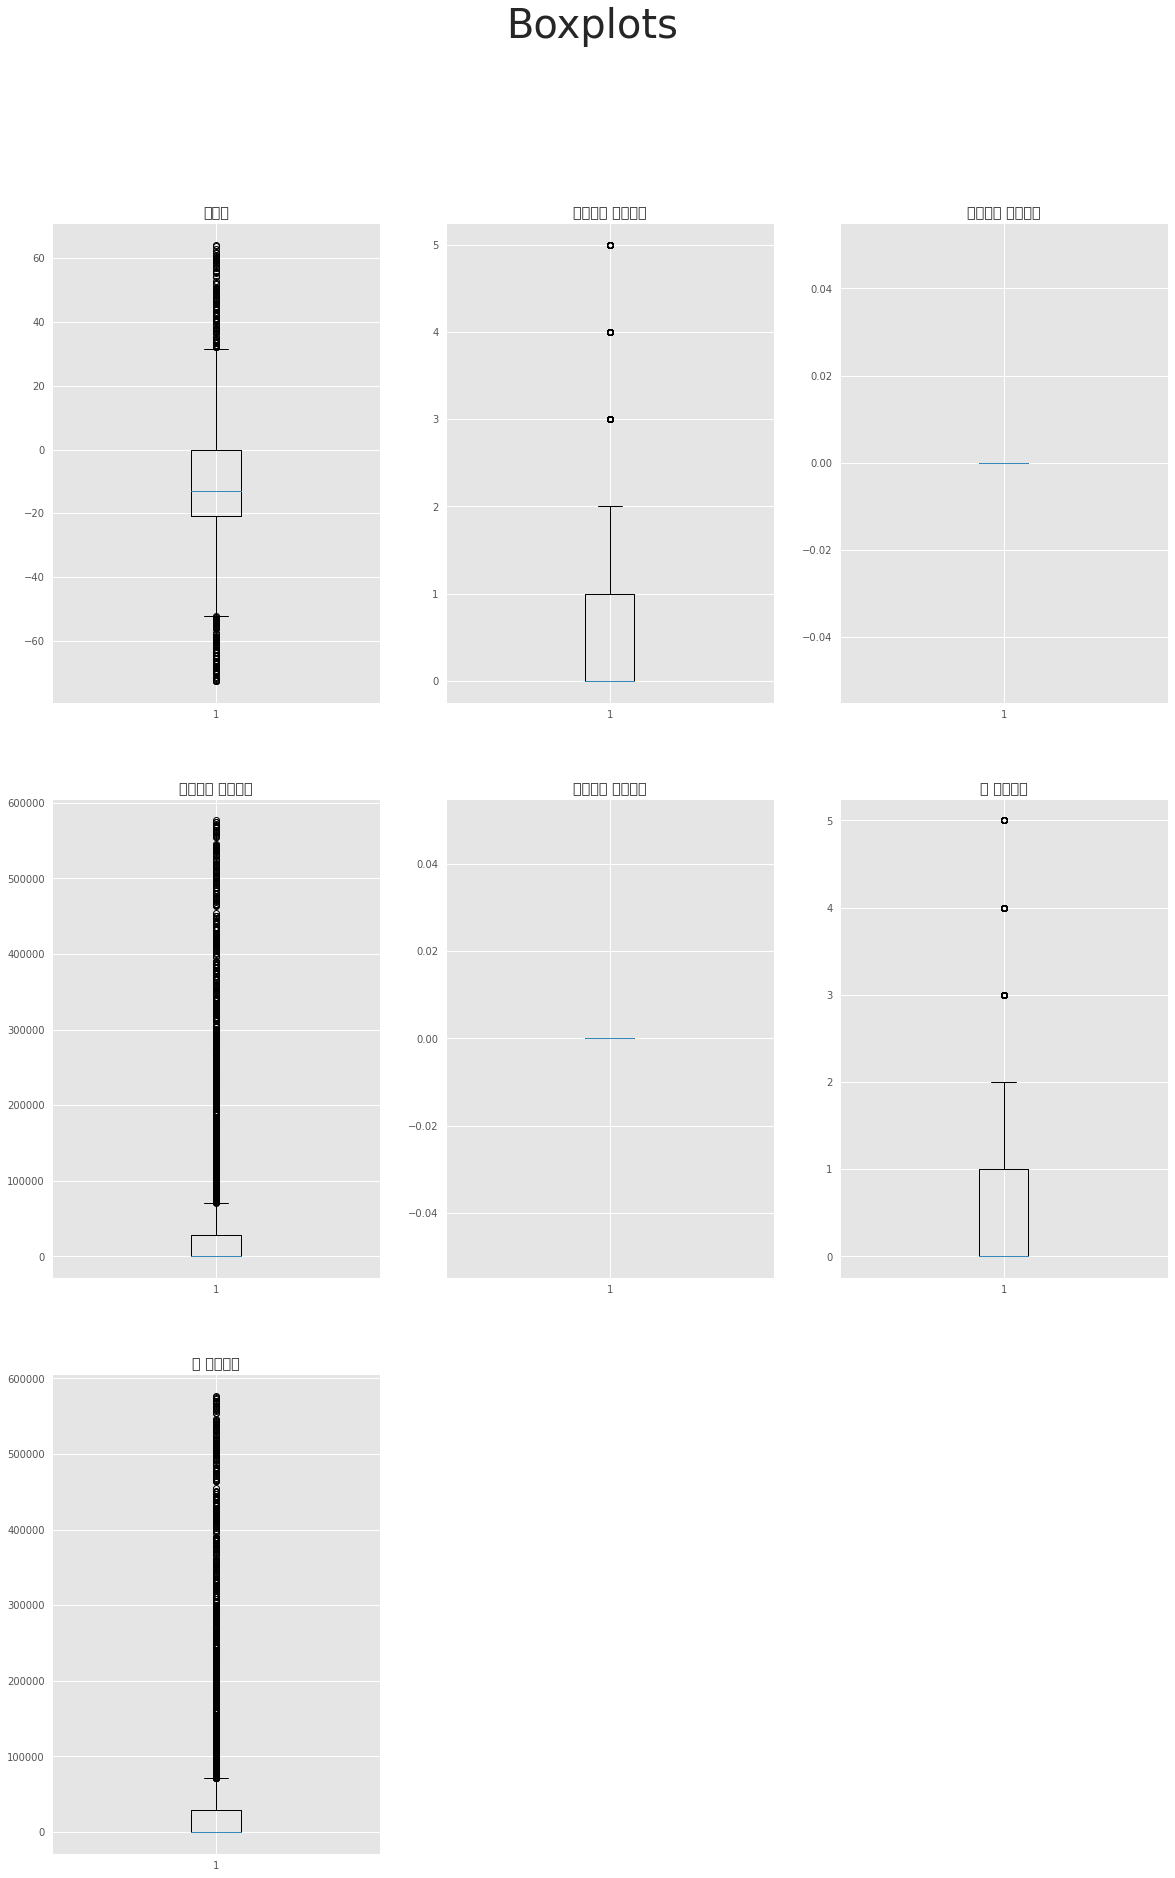

In [83]:
plt.figure(figsize=(20,30))
plt.suptitle("Boxplots", fontsize=40)

for i in range(len(feature)):
    plt.subplot(3,3,i+1)
    plt.title(feature[i])
    plt.boxplot(combined3[feature[i]])
plt.show()

### 범주형 시각화


### 성별
- 성별 구성비율
- 성별 별 거래대금

In [84]:
combined2.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금', '총 거래횟수',
       '총 거래대금'],
      dtype='object')

Text(0.5, 1.0, '성별 별 총 거래대금 비율')

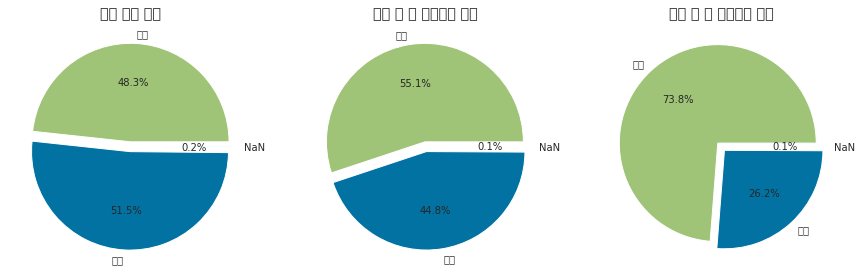

In [85]:
fig, ax = plt.subplots(1,3, figsize=(15, 6))


plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

sex = combined2.groupby('성별').count()['고객번호(가명화)']
# 성별 구성 비율 
ax[0].pie(sex/len(combined2), autopct='%.1f%%',labels=['남성', '여성', 'NaN'], wedgeprops={"linewidth": 1, "edgecolor": "white"}, explode = [0.05, 0.05, 0.05], shadow=False, colors=['g', 'b'])
ax[0].set_title('성별 구성 비율')


# 거래 횟수 
sex_number = combined2.groupby('성별').sum()['총 거래횟수']
ax[1].pie(sex_number/len(combined2), autopct='%.1f%%',labels=['남성', '여성', 'NaN'],wedgeprops={"linewidth": 1, "edgecolor": "white"},explode = [0.05, 0.05, 0.05], shadow=False, colors=['g', 'b'])
ax[1].set_title('성별 별 총 거래횟수 비율')



# # 성별_총거래대금 상대도수 


sex_value = combined2.groupby('성별').sum()['총 거래대금']
ax[2].pie(sex_value/len(combined2), autopct='%.1f%%',labels=['남성', '여성', 'NaN'],wedgeprops={"linewidth": 1, "edgecolor": "white"},explode = [0.05, 0.05, 0.05], shadow=False, colors=['g', 'b'])
ax[2].set_title('성별 별 총 거래대금 비율')





구성 비율은 여성이 미세하게 많지만 총 거래 대금의 구성비가 남성이 73.8%로 훨씬 많은 것을 알 수 있다. 

### 연령대

In [86]:
label = [[],[]]
label_ = '01 미성년 / 02 사회초년생 / 03 가족형성기_남자 / 04 가족형성기_여자 / 05 가족성숙기_직장인 / 06 가족성숙기_주부 / 07 가족성숙기_남자 / 08 가족성숙기_여자 / 09 은퇴기 / 10 노년기 / 99 미정의'
label[0] = label_.split(' / ')

label_ = '01: 25세 미만 / 02: 25세 이상 30세 미만 / 03: 30 세 이상 35세 미만 / 04: 35 세 이상 40세 미만 / 05: 40 세 이상 45세 미만 / 06: 45 세 이상 50세 미만 / 07: 50 세 이상 55세 미만 / 08: 55 세 이상 60세 미만 / 09:  60 세 이상 65세 미만 / 99: 미정의 (NULL 값)'
label[1] = label_.split(' / ')
label


[['01 미성년',
  '02 사회초년생',
  '03 가족형성기_남자',
  '04 가족형성기_여자',
  '05 가족성숙기_직장인',
  '06 가족성숙기_주부',
  '07 가족성숙기_남자',
  '08 가족성숙기_여자',
  '09 은퇴기',
  '10 노년기',
  '99 미정의'],
 ['01: 25세 미만',
  '02: 25세 이상 30세 미만',
  '03: 30 세 이상 35세 미만',
  '04: 35 세 이상 40세 미만',
  '05: 40 세 이상 45세 미만',
  '06: 45 세 이상 50세 미만',
  '07: 50 세 이상 55세 미만',
  '08: 55 세 이상 60세 미만',
  '09:  60 세 이상 65세 미만',
  '99: 미정의 (NULL 값)']]

Text(0.5, 1.0, 'LIFESTAGE세그먼트코드별 거래대금 합')

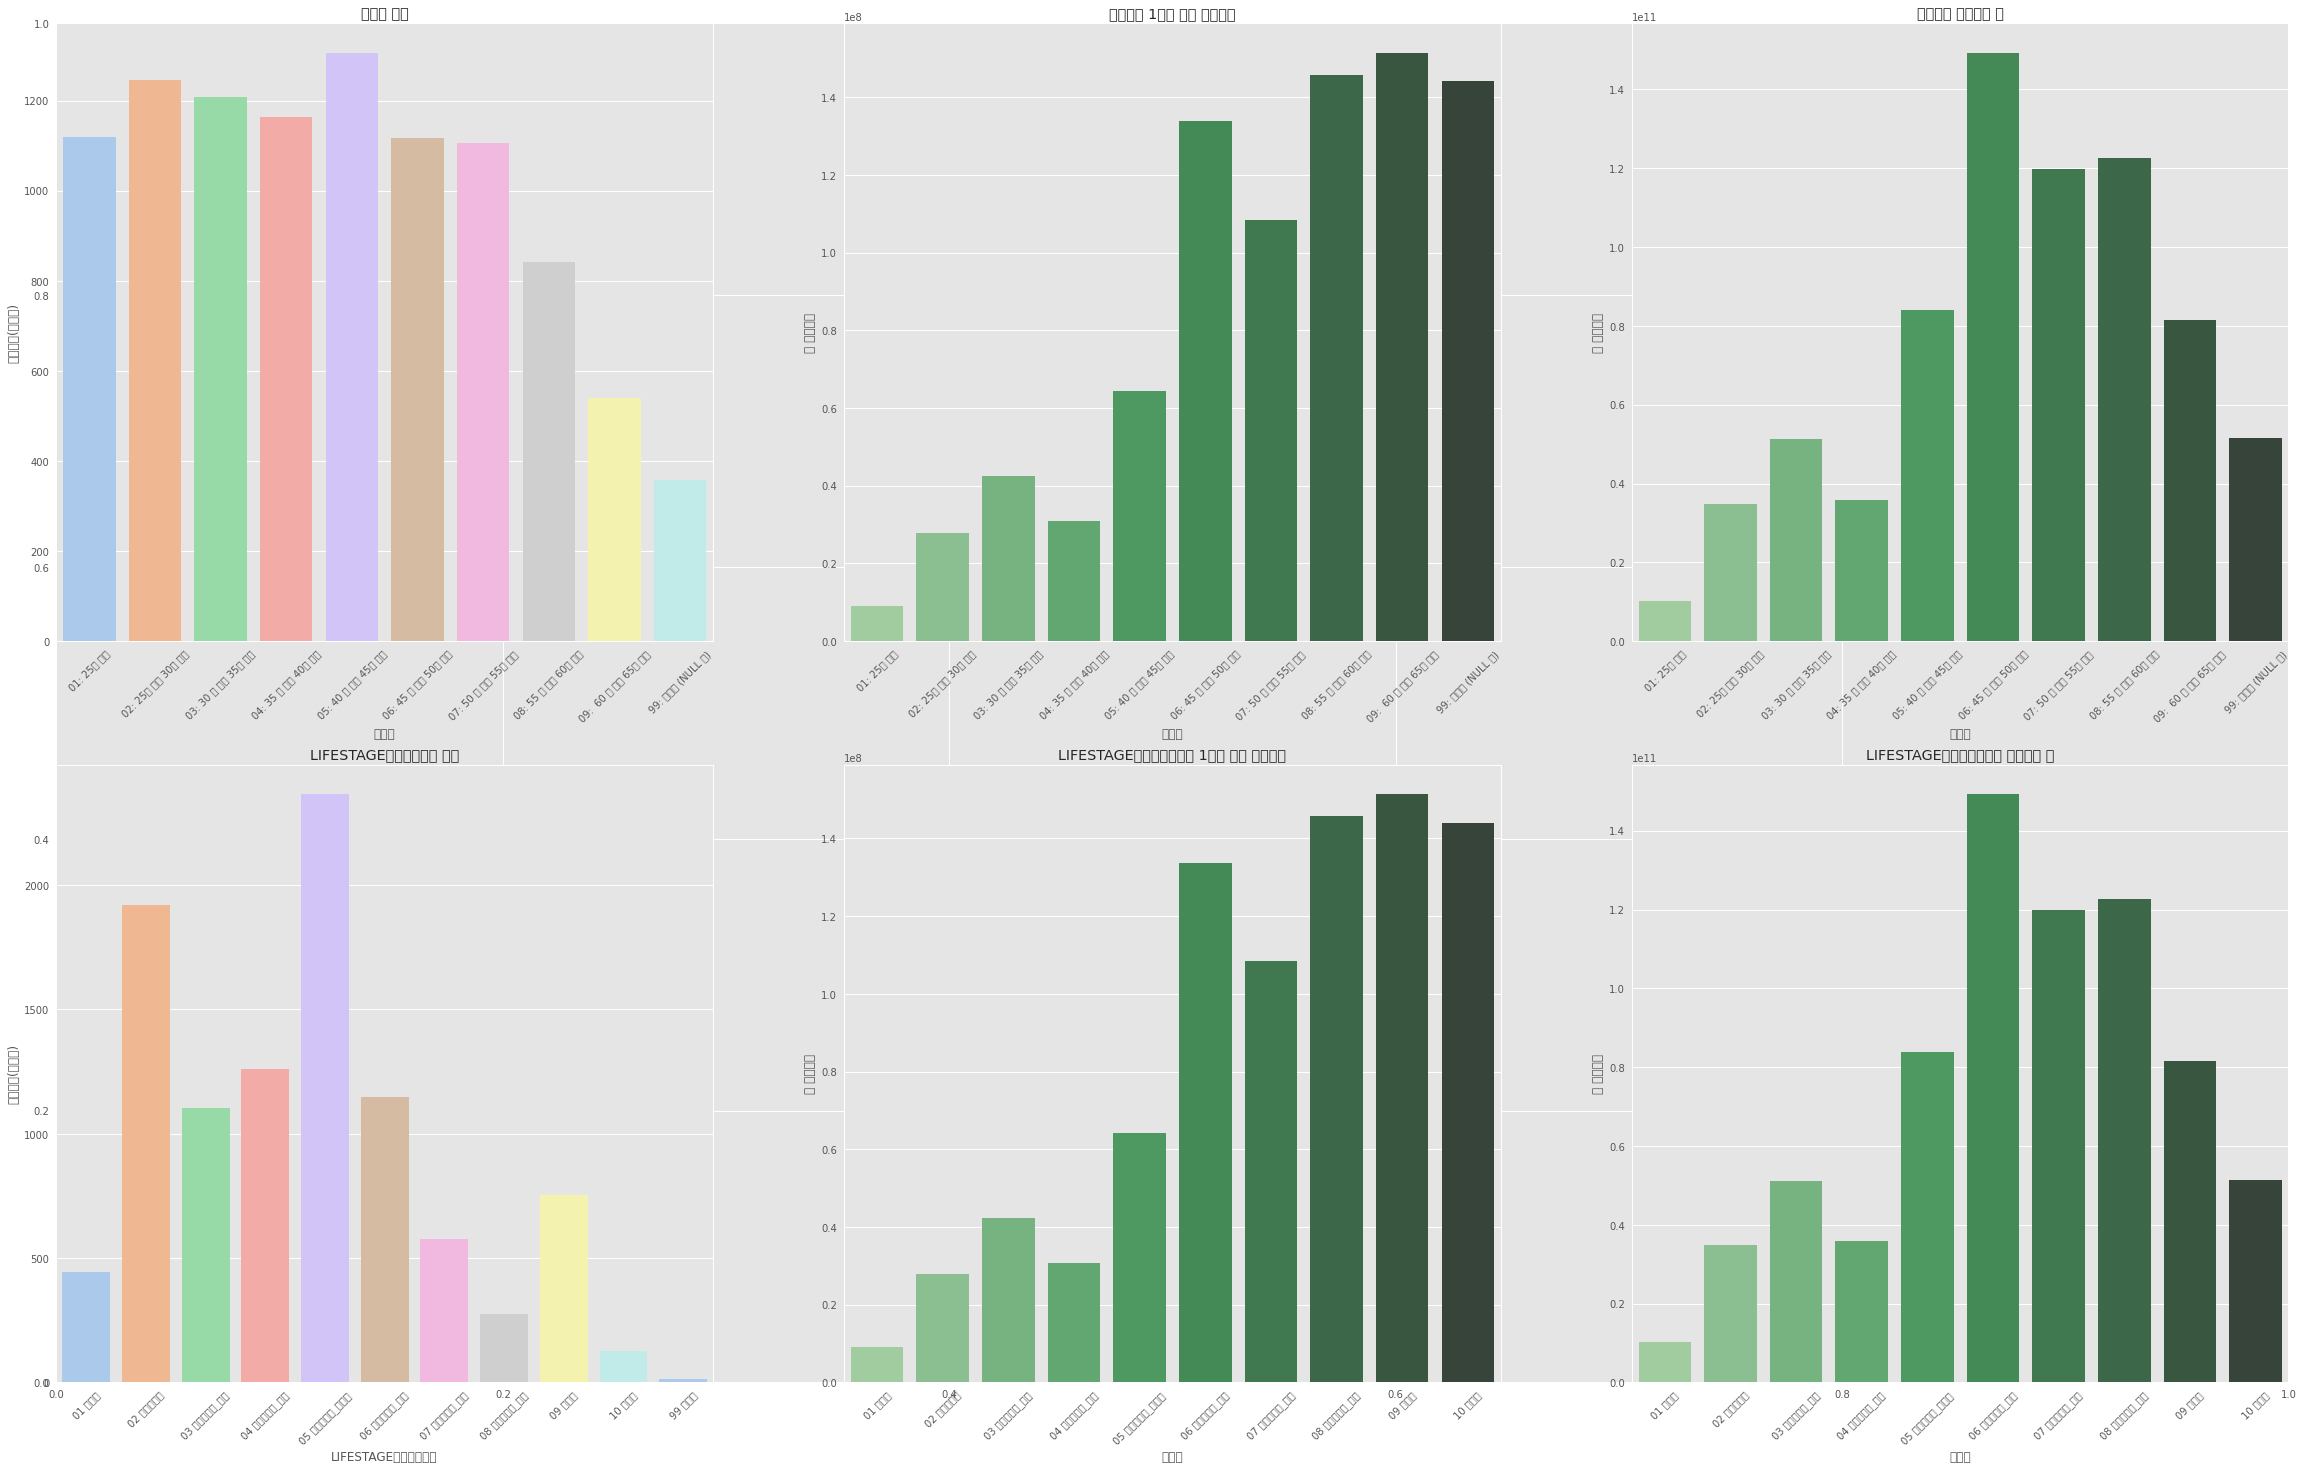

In [87]:
fig, ax = plt.subplots(figsize=(40, 25))


plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

age = combined2.groupby('연령대').count()['고객번호(가명화)']
lifestage = combined2.groupby('LIFESTAGE세그먼트코드').count()['고객번호(가명화)']


plt_1 = fig.add_subplot(2,3,1)
plt_1 = sns.barplot(x=age.index, y=age, palette='pastel')
plt_1.set(xticklabels=label[1])
plt.xticks(rotation=45)
plt_1.set_title('연령대 구성')


plt_2 = fig.add_subplot(2,3,4)
plt_2 = sns.barplot(x=lifestage.index, y=lifestage, palette='pastel')
plt_2.set(xticklabels=label[0])
plt.xticks(rotation=45)
plt_2.set_title('LIFESTAGE세그먼트코드 구성')


# 연령대별 1인당 평균 거래대금 
age_m = combined2.groupby('연령대').mean()['총 거래대금']
# 연령대별 거래대금 합
age_s = combined2.groupby('연령대').sum()['총 거래대금']

plt_3 = fig.add_subplot(2,3,2)
plt_3 = sns.barplot(x=age_m.index, y=age_m, palette='Greens_d' )
plt_3.set(xticklabels=label[1])
plt.xticks(rotation=45)
plt_3.set_title('연령대별 1인당 평균 거래대금')

plt_4 = fig.add_subplot(2,3,3)
plt_4 = sns.barplot(x=age_s.index, y=age_s, palette='Greens_d' )
plt_4.set(xticklabels=label[1])
plt.xticks(rotation=45)
plt_4.set_title('연령대별 거래대금 합')


# LIFESTAGE세그먼트코드별 1인당 평균 거래대금 
lifestage_m = combined2.groupby('LIFESTAGE세그먼트코드').mean()['총 거래대금']
# LIFESTAGE세그먼트코드별 거래대금 합
lifestage_s = combined2.groupby('LIFESTAGE세그먼트코드').sum()['총 거래대금']

plt_5 = fig.add_subplot(2,3,5)
plt_5 = sns.barplot(x=age_m.index, y=age_m, palette='Greens_d' )
plt_5.set(xticklabels=label[0])
plt.xticks(rotation=45)
plt_5.set_title('LIFESTAGE세그먼트코드별 1인당 평균 거래대금')

plt_6 = fig.add_subplot(2,3,6)
plt_6 = sns.barplot(x=age_s.index, y=age_s, palette='Greens_d' )
plt_6.set(xticklabels=label[0])
plt.xticks(rotation=45)
plt_6.set_title('LIFESTAGE세그먼트코드별 거래대금 합')





거래대금이 가장 많은 나이대는 45세에서 60세 사이, 가족성숙기_주부, 남자, 여자이다. 

경제적으로 여유로워질 가족성숙기의 비직장인이 가장 거래가 활발한 것으로 보인다.

### 수익 금액 구간 

In [88]:
label = '01 0 이상 100000 미만 / 02 100000 이상 200000 미만 / 03 200000 이상 300000 미만 / 04 300000 이상 400000 미만 / 05 400000 이상 500000 미만 / 06 500000 이상 1000000 미만 / 07 1000000 이상 2000000 미만 / 08 2000000 이상 3000000 미만 / 09 3000000 이상 4000000 미만 / 10 4000000 이상 5000000 미만 / 11 5000000 이상 6000000 미만 / 12 6000000 이상 7000000 미만  / 13 7000000 이상 8000000 미만 / 14 8000000 이상 9000000 미만 / 15 9000000 이상 10000000 미만 / 16 10000000 이상 30000000 미만 / 17 30000000 이상 50000000 미만 / 18 50000000 이상 100000000 미만 / 19 100000000 이상 300000000 미만 / 20 500000000 이상 1000000000 미만 / 21 1000000000 이상 999999999999999000 미만 / 99 NaN'
label = label.split(' / ')



Text(0.5, 1.0, '수익금액구간코드별 거래대금 합')

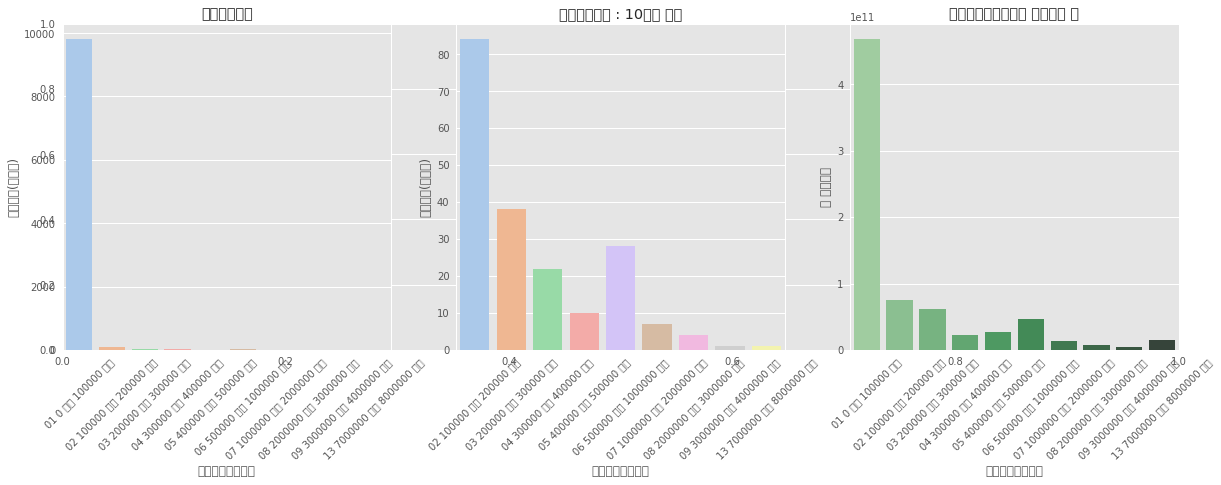

In [89]:
fig, ax = plt.subplots(figsize=(20, 6))


plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')


revenue = combined2.groupby('수익금액구간코드').count()['고객번호(가명화)']

plt_1 = fig.add_subplot(1,3,1)
plt_1 = sns.barplot(x=revenue.index, y=revenue, palette='pastel' )
plt_1.set(xticklabels=label[:9]+label[12:14])
plt.xticks(rotation=45)
plt_1.set_title('수익금액구간')


plt_2 = fig.add_subplot(1,3,2)
plt_2 = sns.barplot(x=revenue.index[1:], y=revenue[1:], palette='pastel' )
plt_2.set(xticklabels=label[1:9]+label[12:14])

plt.xticks(rotation=45)
plt_2.set_title('수익금액구간 : 10만원 이상')


revenue_s = combined2.groupby('수익금액구간코드').sum()['총 거래대금']


plt_3 = fig.add_subplot(1,3,3)
plt_3 = sns.barplot(x=revenue_s.index, y=revenue_s, palette='Greens_d' )
plt_3.set(xticklabels=label[:9]+label[12:14])
plt.xticks(rotation=45)
plt_3.set_title('수익금액구간코드별 거래대금 합')





### 주문 매체 비율

In [90]:
label = '01:영업점단말/02:유선단말/03:무선단말/04:HTS/09,05:기타'
label = label.split('/')


In [91]:
total_ko_ = pd.merge(info_data, kr_data, on= '계좌번호(가명화)' )


([<matplotlib.patches.Wedge at 0x7fa8622a28d0>,
 [Text(1.149999993462815, 0.00012261943478787912, '01:영업점단말'),
  Text(1.1499995178316802, 0.0010530844711662064, '02:유선단말'),
  Text(-1.1213992457443087, 0.2548798376570719, '03:무선단말'),
  Text(1.121192631732326, -0.2557871821439473, '04:HTS')],
 [Text(0.6499999963050692, 6.930663705401863e-05, '0.0%'),
  Text(0.6499997274700801, 0.0005952216576156819, '0.0%'),
  Text(-0.6338343562902615, 0.14406251693660582, '92.8%'),
  Text(0.6337175744574016, -0.14457536382049194, '7.1%')])

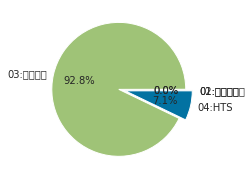

In [92]:
order = total_ko_.groupby('주문매체구분코드').count()['고객번호(가명화)']


fig, ax = plt.subplots(figsize=(3, 4))


plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

ax.pie(order, autopct='%.1f%%',labels=label[:4], wedgeprops={"linewidth": 1, "edgecolor": "white"}, explode = [0.05]*len(order), shadow=False, colors=['g', 'b'])


### 주식 거래 유형

In [93]:
label = '001 Scalper / 002 Day Trader / 003 Swing Trader / 004 General Trader / 005 Occasional Trader / 006 Long-Term Trader / 007 입고,공모,배당 / 008 Recent Dormancy / 009 Dormancy / 010 Stock Holder / 011 Break Out / _ 해당사항없음'
label = label.split(' / ')
label



['001 Scalper',
 '002 Day Trader',
 '003 Swing Trader',
 '004 General Trader',
 '005 Occasional Trader',
 '006 Long-Term Trader',
 '007 입고,공모,배당',
 '008 Recent Dormancy',
 '009 Dormancy',
 '010 Stock Holder',
 '011 Break Out',
 '_ 해당사항없음']

Text(0.5, 1.0, '기본주식거래유형별 거래대금 합')

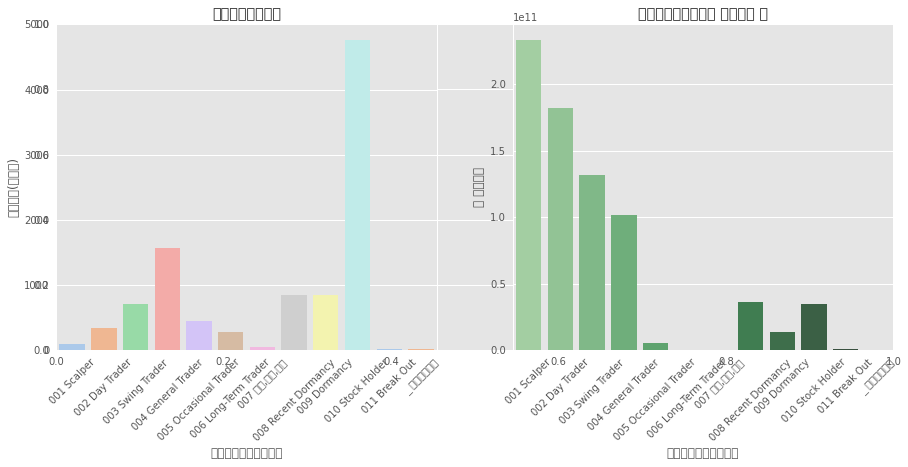

In [94]:
fig, ax = plt.subplots(figsize=(15, 6))


plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

 
transaction_type = combined2.groupby('기본주식거래유형코드').count()['고객번호(가명화)']



plt_1 = fig.add_subplot(1,2,1)
plt_1 = sns.barplot(x=transaction_type.index, y=transaction_type, palette='pastel' )
plt_1.set(xticklabels=label)
plt.xticks(rotation=45)
plt_1.set_title('기본주식거래유형')

transaction_type_s = combined2.groupby('기본주식거래유형코드').sum()['총 거래대금']

plt_2 = fig.add_subplot(1,2,2)
plt_2 = sns.barplot(x=transaction_type_s.index, y=transaction_type_s, palette='Greens_d' )
plt_2.set(xticklabels=label)

plt.xticks(rotation=45)
plt_2.set_title('기본주식거래유형별 거래대금 합')







대부분의 투자자가 Stock Holder지만, 
거래 특성상 거래대금은 Scalper가 가장 높은 것을 볼 수 있다. 

### 해외주식 국내주식 비교 

거래횟수 

In [95]:
combined2.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금', '총 거래횟수',
       '총 거래대금'],
      dtype='object')

In [96]:
new_df = pd.DataFrame()
new_df['전체 거래횟수'] = [sum(combined2['국내주식 거래횟수']) + sum(combined2['해외주식 거래횟수'])]
new_df['국내 거래횟수'] = [sum(combined2['국내주식 거래횟수'])]
new_df['해외 거래횟수'] = [sum(combined2['해외주식 거래횟수'])]

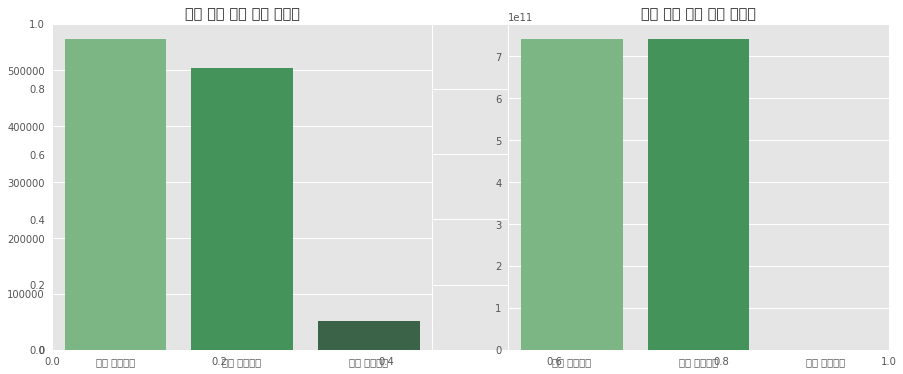

In [97]:
fig, ax = plt.subplots(figsize=(15, 6))

new_df = pd.DataFrame()
new_df['전체 거래횟수'] = [sum(combined2['국내주식 거래횟수']) + sum(combined2['해외주식 거래횟수'])]
new_df['국내 거래횟수'] = [sum(combined2['국내주식 거래횟수'])]
new_df['해외 거래횟수'] = [sum(combined2['해외주식 거래횟수'])]
plt_1 = fig.add_subplot(1, 2 ,1)
plt_1 = sns.barplot(x=new_df.columns, y=new_df.values[0] ,palette="Greens_d")
plt_1.set_title('전체 주식 거래 횟수 시각화', weight='bold')



new_df = pd.DataFrame()
new_df['전체 거래대금'] = [sum(combined2['총 거래대금'])]
new_df['국내 거래대금'] = [sum(combined2['국내주식 거래대금'])]
new_df['해외 거래대금'] = [sum(combined2['해외주식 거래대금'])]


plt_2 = fig.add_subplot(1, 2 ,2)
plt_2 = sns.barplot(x=new_df.columns, y=new_df.values[0] ,palette="Greens_d")
plt_2.set_title('전체 주식 거래 대금 시각화', weight='bold')



plt.show()

# 군집분석

이상값을 제외한 combined3를 사용합니다

In [98]:
combined3.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드',
       '해외주식상품보유여부', '주거래상품군', 'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드',
       '보유상품유형세그먼트코드', '충성도세그먼트코드', '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드',
       '변동률', '국내주식 거래횟수', '해외주식 거래횟수', '국내주식 거래대금', '해외주식 거래대금', '총 거래횟수',
       '총 거래대금'],
      dtype='object')

In [99]:
combined3.loc[combined3['기본주식거래유형코드']=='_  ', '기본주식거래유형코드'] = 99


In [101]:
combined3['기본주식거래유형코드'].value_counts()

010    3213
009     177
005     127
008     112
006     102
004      72
99       17
007      17
011       3
Name: 기본주식거래유형코드, dtype: int64

In [102]:
combined3 = combined3.drop('해외주식상품보유여부',axis=1)

In [103]:

dict_combined_cus = {d:i for d,i in enumerate(combined3['고객번호(가명화)'])}

dict_combined_act = {d:i for d,i in enumerate(combined3['계좌번호(가명화)'])}


set_combined = combined3.drop(['고객번호(가명화)', '계좌번호(가명화)'],axis=1)


In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

combined_sc = scaler.fit_transform(set_combined)



In [105]:
def plot_Silhouette(data,  k, text):
    km = KMeans(n_clusters=k, init='k-means++', random_state=119)
    km.fit(data)

    fig = plt.figure()
    fig.set_size_inches(15, 5)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
    visualizer.fit(data)

    visualizer.ax.set_title(text,fontsize=15, weight='bold')
    visualizer.ax.set_xlabel("Silhouette Value",fontsize=15, weight='bold')
    visualizer.ax.set_ylabel("군집",fontsize=15, weight='bold')
    visualizer.ax.set_yticks([])

    plt.show()

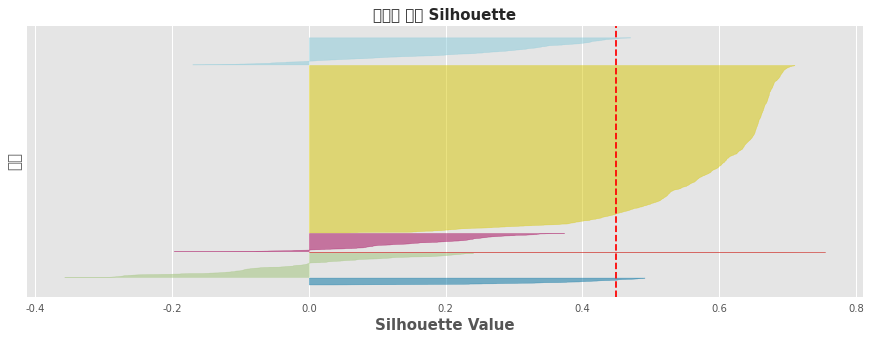

In [106]:
plot_Silhouette(combined_sc, 6, '고객군 군집 Silhouette')

In [107]:
combined3['변동률'] = round(combined3['변동률'] ,2)


In [108]:
km = KMeans(n_clusters=6, init='k-means++', random_state=119).fit(combined_sc)

combined3['군집'] = km.predict(combined_sc)


### 군집 시각화

In [113]:
def group_plot(df, g, name_list):

  fig, axes = plt.subplots(g,len(name_list),figsize=(50, 20))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for i in range(g):
    for num in range(len(name_list)):

      if num != len(name_list)-1 :
        plot1 = sns.countplot(x=name_list[num], data=df.loc[df['군집'] == i], order = df.loc[df['군집'] == i][name_list[num]].value_counts().iloc[:5].index[::-1], ax=axes[i, num]) 
        plot1.set_title(f'군집 : {i}' + ' ' + name_list[num] ,fontsize=15 , weight='bold')
        plot1.set_xlabel(' ')
        plot1.set_ylabel(' ')

      else:
        plot1 = sns.countplot(x=name_list[num], data=df.loc[df['군집'] == i], order = df.loc[df['군집'] == i][name_list[num]].value_counts().iloc[:5].index[::-1], ax=axes[i, num]) 
        plot1.set_title(f'군집 : {i}' + ' ' + name_list[num] ,fontsize=15 , weight='bold')
        plot1.set_xlabel(' ')
        plot1.set_ylabel(' ')
        plot1.set(xticklabels=[])

  

  plt.show()

In [114]:
def group_plot2(df, text, name_list):

  fig, axes = plt.subplots(1,len(name_list),figsize=(20, 10))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for i in range(len(name_list)):

    plot1 = sns.barplot(x=name_list[i], y = '군집', data=df, orient='h', ci=None , ax=axes[i]) 
    plot1.set_title(f'{text}' + ' ' + name_list[i] + ' ' + '평균' ,fontsize=15 , weight='bold')
    plot1.set_xlabel(' ')
    plot1.set_ylabel('군집')

  plt.show()
    

In [115]:
combined3.columns

Index(['고객번호(가명화)', '계좌번호(가명화)', '성별', '연령대', '고객자산구간코드', '수익금액구간코드', '주거래상품군',
       'LIFESTAGE세그먼트코드', '총투자기간세그먼트코드', '보유상품유형세그먼트코드', '충성도세그먼트코드',
       '주거래시장구분코드', '주거래업종구분코드', '기본주식거래유형코드', '변동률', '국내주식 거래횟수', '해외주식 거래횟수',
       '국내주식 거래대금', '해외주식 거래대금', '총 거래횟수', '총 거래대금', '군집'],
      dtype='object')

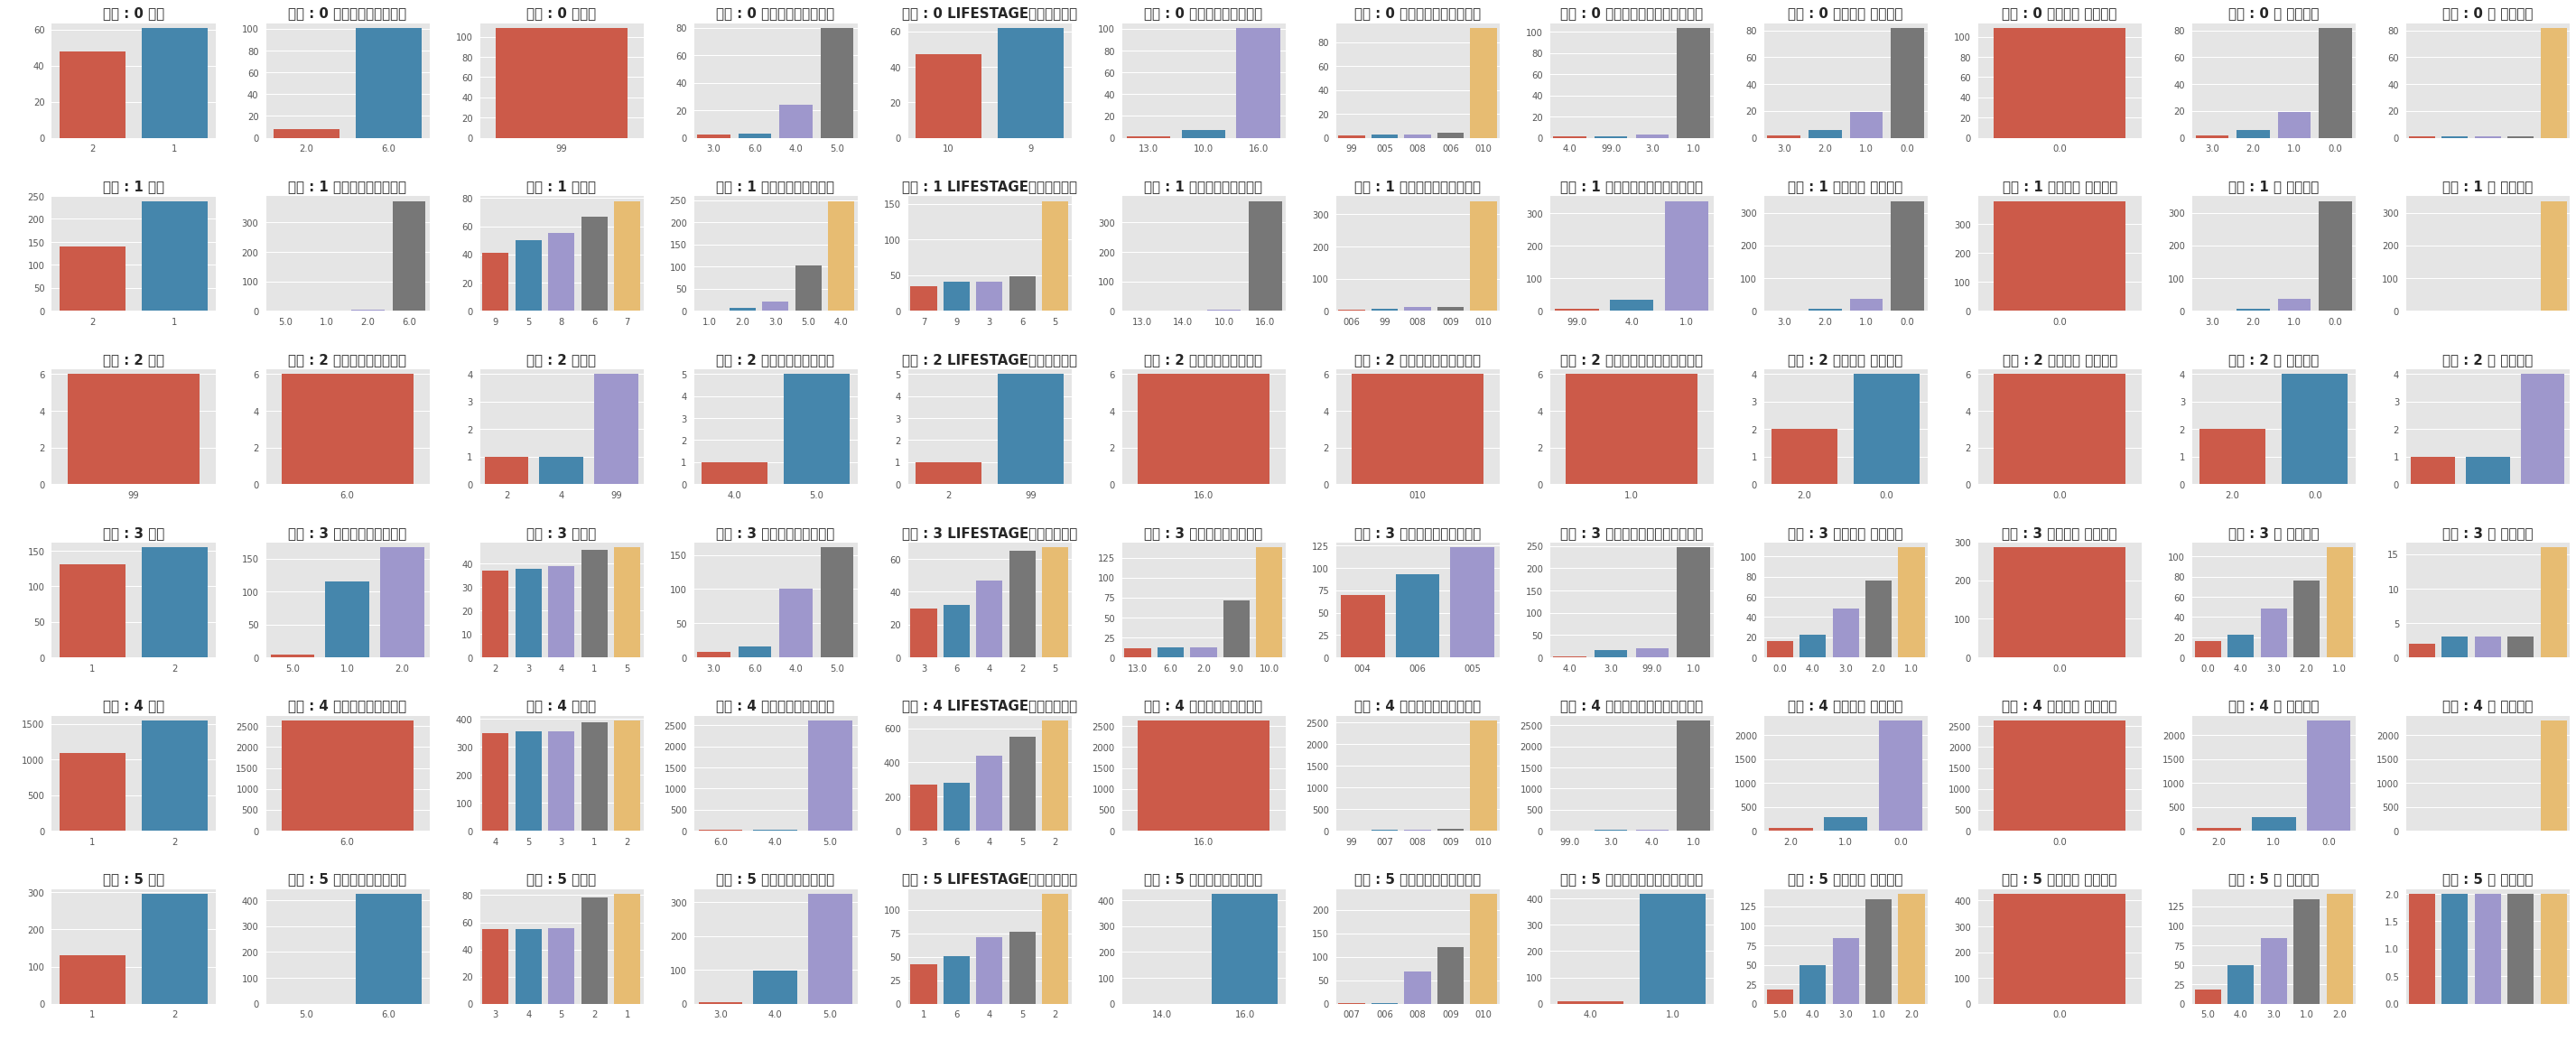

In [116]:
name_list = ['성별', '주거래시장구분코드', '연령대', '충성도세그먼트코드', 'LIFESTAGE세그먼트코드', '주거래업종구분코드','기본주식거래유형코드', '보유상품유형세그먼트코드','국내주식 거래횟수', '해외주식 거래횟수', '총 거래횟수', '총 거래대금']
group_plot(combined3, 6, name_list)

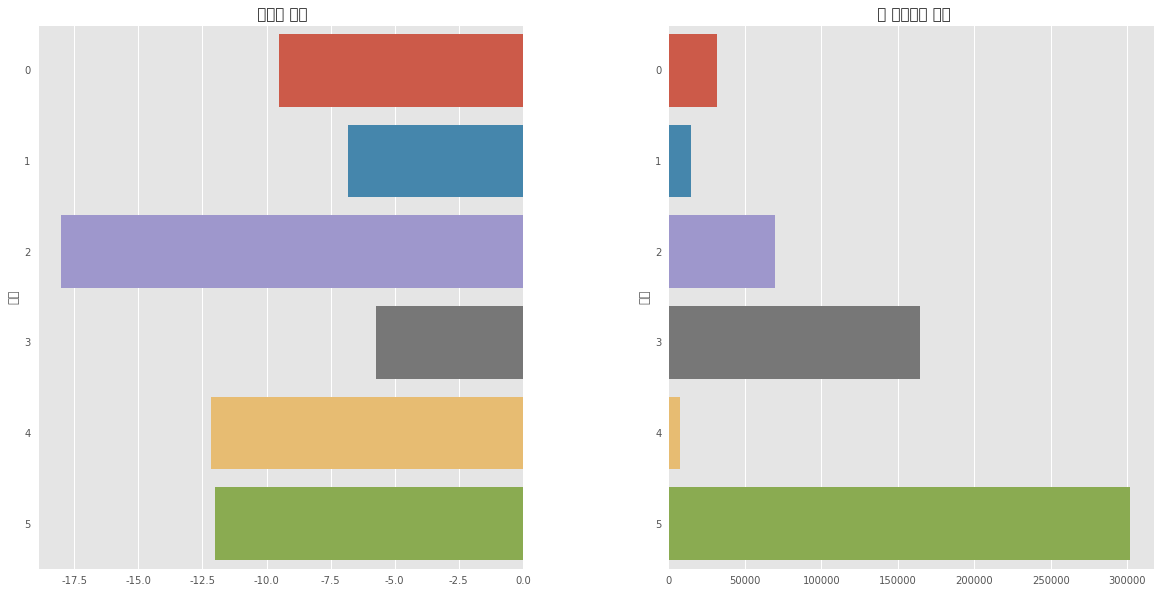

In [117]:
name_list = ['변동률', '총 거래대금']
group_plot2(combined3, '',  name_list)



&nbsp;

- 0번 군집
  - 주로 은퇴기, 노년기로 비매매를 합니다. 
  - 거래횟수와 거래대금이 거의 없고 자산의 변동이 중간정도입니다.

- 1번 군집
  - 다양한 연령대의 가족성숙기 직장인으로 구성되어있습니다.
  - 거의 거래를 하지 않습니다. 
  - 직장인이라 거래를 거의 하지 않는 것으로 보여 시간을 적게 쏟을 수 있도록 적절한 상품을 추천하는 것이 좋아보입니다. 

- 2번 군집
  - 매매를 거의 하지 않지만 자산의 변동률이 가장 큽니다.
  - 주식 거래를 가끔씩만 하는 것으로 보여 적절한 마케팅을 통해 관심을 갖도록 유도해주면 좋을 것 같습니다. 

- 3번 군집
  - 국내 주식 거래를 주로 합니다. 
  - 거래대금이 꽤 크면서 변동률은 크지 않습니다. 
  - 3번 군집을 참고해 1번 군집에게 추천해주면 좋을 것 같습니다.

- 4번 군집
  - 다양한 연령대로 이루어져있습니다. 
  - 거래대금이 가장 적은 군집입니다. 

- 5번 군집
  - 50~55 사이의 가족 성숙기 직장인이 가장 많이 차지하고
  - 거래소를 통해 주로 거래합니다.
  - 거래대금이 가장 많은 군집입니다. 

&nbsp;



In [118]:
combined3.to_csv('고객 분류 결과 파일.csv', encoding='utf-8')